# HSI ReconClsNet
### Single-Cube Learning with Physics-Guided Augmentation and Two-Stage Neural Modeling

This notebook presents a **scene-adaptive hyperspectral imaging (HSI) classification framework**
inspired by the human-inspired “machine education” approach proposed by  
**Kendler et al., Scientific Reports (2022)**.

---

## Motivation

Hyperspectral chemical identification is strongly affected by:
- Illumination conditions
- Background material variability
- Nonlinear spectral mixing between background and contaminant materials

Training a model that **generalizes across many scenes and lighting conditions** is therefore
challenging, data-intensive, and expensive. This challenge is particularly relevant in HSI,
where data acquisition is slow, costly, and often limited to a small number of scenes.

Rather than attempting to learn a globally illumination-invariant model,  
we explore an **alternative and complementary regime**:

> **Scene-adaptive learning — fitting a model directly to a single hyperspectral cube.**

---

## Conceptual Shift: From Global Generalization to Scene Adaptation

The original paper focuses on generalization across multiple hyperspectral cubes.
In contrast, this work intentionally adopts a **single-cube classifier**.

Key assumptions:
- Illumination and background statistics are *fixed within a single cube*
- Once these statistics are learned, the physics of spectral mixing is known
- Scene-specific adaptation is often more practical than global generalization

We therefore trade global robustness for **fast, accurate, scene-specific detection**.

---

## Pixel-Level Learning Paradigm

Each pixel in a hyperspectral cube is treated as a **single sample**:
- A cube of size (H x W x B) corresponds to H x W samples
- Each sample is a B-dimensional spectral vector

When splitting data:
- Training and testing refer to **pixels**, not cubes
- Only a small fraction (p%) of pixels is used for training
- The remaining pixels are used for detection within the same scene

---

## Physics-Guided Data Augmentation

Instead of relying on labeled contaminated pixels, training data is generated using:
- Clean background pixels from the same cube
- Reference spectral signatures of target materials
- A known nonlinear spectral mixing model

This allows the creation of **synthetic contaminated spectra** that:
- Match the scene’s illumination conditions
- Preserve realistic background variability

As a result, the model can detect contamination without requiring
a large labeled dataset or multiple scenes.

---

## Two-Stage Neural Pipeline

To operationalize this idea, we propose a **two-stage, scene-adaptive network pipeline**:

### Stage 1 — Reconstruction Network (ReconNet)
- Learns the background and illumination distribution of the scene
- Suppresses scene-specific disturbances
- Reconstructs a material-focused spectral representation
- Trained intentionally on the single cube

ReconNet is implemented using a **U-Net architecture**, inspired by its
widespread success in denoising and signal separation tasks.
The encoder-decoder structure and skip connections enable separation
between background/illumination effects and material-specific signatures.

### Stage 2 — Classification Network (ClsNet)
- Receives both:
  - The original mixed spectrum
  - The reconstructed spectrum from ReconNet
- Performs pixel-level material classification

Conceptually:
> *ReconNet learns the scene.*  
> *ClsNet decides the material.*

This separation reduces the burden on the classifier and improves
data efficiency.

---

## Key Idea in One Sentence

We propose a **scene-adaptive, two-stage hyperspectral classification framework**
that learns illumination and background from a single cube and uses
physics-guided augmentation to detect chemical contamination without
requiring large multi-scene datasets.


## Pipeline Overview (Single-Cube, Two-Stage Learning)



In [ ]:
# ┌─────────────────────────────┐
# │  Hyperspectral Cube (H×W×B) │
# │  • Fixed illumination       │
# │  • Fixed background         │
# └──────────────┬──────────────┘
#                │
#                ▼
# ┌─────────────────────────────┐
# │  Clean Pixel Selection (p%) │
# │  • Pixel-level samples      │
# │  • No cube-level splitting  │
# └──────────────┬──────────────┘
#                │
#                ▼
# ┌────────────────────────────────────────┐
# │ Physics-Guided Spectral Augmentation   │
# │ • Reference material spectra           │
# │ • Nonlinear mixing model               │
# │ • Scene-matched synthetic data         │
# └──────────────┬─────────────────────────┘
#                │
#                ▼
# ┌────────────────────────────────────────┐
# │ Reconstruction Network (ReconNet)      │
# │ • U-Net architecture                   │
# │ • Learns illumination & background     │
# │ • Produces denoised / material-focused │
# │   spectral representations             │
# └──────────────┬─────────────────────────┘
#                │
#                ▼
# ┌────────────────────────────────────────┐
# │ Joint Representation                   │
# │ • Original spectrum                    │
# │ • Reconstructed spectrum               │
# └──────────────┬─────────────────────────┘
#                │
#                ▼
# ┌────────────────────────────────────────┐
# │ Classification Network (ClsNet)        │
# │ • Pixel-level material classification │
# │ • Scene-adaptive decision making       │
# └──────────────┬─────────────────────────┘
#                │
#                ▼
# ┌────────────────────────────────────────┐
# │ Contamination Map                      │
# │ • Pixel-wise material labels           │
# │ • Entire cube processed                │
# └────────────────────────────────────────┘


# Hyperspectral Contamination Detection


## Imports and Device Selection

In [ ]:
!pip install spectral

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 16.8 MB/s eta 0:00:00


In [ ]:
# ======================================================================
# IMPORTS
# ======================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

from spectral import open_image
from matplotlib.patches import Patch

# Machine learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
)

import seaborn as sns

plt.rcParams["figure.dpi"] = 120

from IPython.display import display

# ==========================================
# DEVICE
# ==========================================
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on:", DEVICE)

Running on: cuda


# PART 1 - MODEL-SPECIFIC IMPLEMENTATION

## CONFIG

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
base = rf"/content/drive/MyDrive/HSI"
data_path = rf"{base}/data"

Mounted at /content/drive/


In [ ]:
# Base paths for this experiment
BASE_DIR   = r"/content/drive/MyDrive/HSI"      # <-- EDIT TO YOUR PATH
DATA_DIR   = rf"{BASE_DIR}/data"
CUBE_NAME = "cube_ziv"
CUBE_PATH  = rf"{DATA_DIR}/{CUBE_NAME}"
HDR_PATH   = rf"{CUBE_PATH}/Standart_2017-10-16_08-32-58.hdr"
REF_CSV_PATH = rf"{DATA_DIR}/Ref.csv"

CACHE_DIR = rf"{CUBE_PATH}/dataset_cache"
GT_PATH    = HDR_PATH.replace(".hdr", "_GT.npz")

MODEL_NAME = "ReconClsNet"

# Recon model
LOAD_MODEL_SAVED = True # if True and MODEL_PATH exists, skip training
MODEL_PATH = rf"{CACHE_DIR}/diffusion_model_{MODEL_NAME}.pth"
if LOAD_MODEL_SAVED:
  MODEL_PATH = rf"/content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_recon.pth"

# Cls model
LOAD_CLS_MODEL = True
MODEL_CLS_PATH = None
if LOAD_CLS_MODEL:
  MODEL_CLS_PATH = rf"/content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_cls.pth"

OUT_PREFIX = os.path.splitext(HDR_PATH)[0] + f"_{MODEL_NAME}"
PRED_PATH  = OUT_PREFIX + "_predictions.npz"

# data releted globals
REMOVE_DARK = True
OVERWRITE_FULL_CUBE_TENSOR_PT = True
OVERWRITE_DATASET_CACHE = True
DATA_CACHE_PATH = os.path.join(CACHE_DIR, os.path.basename(os.path.splitext(HDR_PATH)[0])+'_prepared_data.pt')

# file where you can put 1 to halt train in the middle of the training
STOP_FLAG_PATH = f"{BASE_DIR}/stop_flag.txt"


# Model / training hyperparameters
HP ={
    # data related hyperparameters
    "CLEAN_TRAIN_FRACTION": 0.3,
    "N_SAMPLES": 10000,

    # training related hyperparameters
    "BATCH_SIZE": 64,
    "STEP_LR_SIZE": 15,
    "STEP_LR_GAMMA": 0.85,

    # Recon train
    "EPOCHS": 50,
    "LR": 1e-4,
    "LAMBDA_CORR": 1.0,

    # Cls train
    "EPOCHS_CLS": 50,
    "LR_CLS": 1e-4,

    # visual
    "CORR_TH": 0.3,
    "K_SMOOTH": 7,
    "K_BLOCK" : 3,
    "TRESH_BLOCK": 0.2,
    "TRESH_POLY": 0.2,
}

# 🧠 Define Model

### Expline


##Dataset

### Description

The dataset consists of hyperspectral cubes captured in the SWIR range (~1000 to ~2500 nm).

Each cube contains:
- Three background surfaces:
  - Ceramic tile
  - Plywood
  - Cardboard
- Thin contaminant layers of:
  - Sugar (Su)
  - Polystyrene (PS)
  - Silicone oil (Si)

#### Dataset

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, clean_set, bg_set, ps, si, su, n_samples=10000):
        self.clean_set = clean_set
        self.bg_set = bg_set
        self.n = n_samples

        # Chemical signatures (0 to 1 transmittance)
        self.materials = {1: None, 2: ps, 3: si, 4: su}

    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        # 1. Randomly select background (Raw Counts)
        bg = self.bg_set[idx]

        # 2. Choose label
        meta = np.random.choice([1, 2, 3, 4])
        meta = (idx % 4) + 1   # cycles 1,2,3,4 evenly

        # 3. Construct the Clean Target (Rm)
        if meta == 1:
            # None: Transmittance is 1.0 (Transparent)
            Rm = np.ones_like(bg)
        else:
            # Material: The chemical signature (0.0 - 1.0)
            Rm = self.materials[meta]

        return (
            torch.tensor(Rm, dtype=torch.float32),  # Target (0-1)
            torch.tensor(bg, dtype=torch.float32),  # Background (Raw Counts)
            torch.tensor(meta - 1, dtype=torch.long)
        )

### dataset wrapper

In [ ]:
def create_train_dataset(train_clean, bg, Si, Sugar, PS):
    """
    FACTORY for the training dataset. Change this if synthetic generation changes.
    """
    train_dataset =  TrainDataset(
      clean_set=train_clean,
      bg_set=bg,
      ps=PS,
      si=Si,
      su=Sugar,
      n_samples=HP["N_SAMPLES"],
    )

    return train_dataset

## 4. 🧠 Model

#### ReconUNet

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, 3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.act = nn.SiLU()
        self.conv2 = nn.Conv1d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, 1)

    def forward(self, x):
        residual = self.shortcut(x)
        x = self.act(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        return self.act(x + residual)

class ReconUNet(nn.Module):
    def __init__(self, B_channels):
        super().__init__()

        # Encoder
        self.inc = nn.Conv1d(1, 64, 3, padding=1)
        self.down1 = ResidualBlock(64, 128)
        self.pool1 = nn.MaxPool1d(2)
        self.down2 = ResidualBlock(128, 256)
        self.pool2 = nn.MaxPool1d(2)

        # Bottleneck
        self.bot = ResidualBlock(256, 512)

        # Decoder
        self.up1 = nn.ConvTranspose1d(512, 256, 2, stride=2)
        self.up_block1 = ResidualBlock(512, 256)

        self.up2 = nn.ConvTranspose1d(256, 128, 2, stride=2)
        self.up_block2 = ResidualBlock(256, 128)

        # Output Head: Predicts Clean Signal directly
        self.out_c = nn.Conv1d(128, 1, 1)

    def forward(self, x):
        # x: [Batch, 1, Length]

        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.pool1(x2)
        x4 = self.down2(x3)
        x5 = self.pool2(x4)

        # Bottleneck
        x_bot = self.bot(x5)

        # Decoder
        x_up1 = self.up1(x_bot)
        if x_up1.shape[2] != x4.shape[2]: # Handle odd pooling
            x_up1 = nn.functional.interpolate(x_up1, size=x4.shape[2])

        x_cat1 = torch.cat([x4, x_up1], dim=1)
        x_out1 = self.up_block1(x_cat1)

        x_up2 = self.up2(x_out1)
        if x_up2.shape[2] != x2.shape[2]:
            x_up2 = nn.functional.interpolate(x_up2, size=x2.shape[2])

        x_cat2 = torch.cat([x2, x_up2], dim=1)
        x_out2 = self.up_block2(x_cat2)

        # Output
        recon = self.out_c(x_out2)
        return recon

#### ClsNet

In [ ]:
class ClsNet(nn.Module):
    """
    Takes two traces:
      x_in   : [B,1,Bands]  (the cube trace you feed recon net; augmented or not)
      x_recon: [B,1,Bands]  (reconstructed trace from recon net)
    Output:
      logits : [B,4]
    """
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(2, 64, 7, padding=3), nn.ReLU(),
            nn.Conv1d(64, 128, 5, padding=2), nn.ReLU(),
            nn.Conv1d(128, 256, 5, padding=2), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x_in, x_recon):
        x = torch.cat([x_in, x_recon], dim=1)  # [B,2,B]
        f = self.conv(x).squeeze(-1)           # [B,256]
        return self.fc(f)                      # [B,4]


### model wrapper

In [ ]:
def create_model(Bwin: int):
    """
    Wrapper for calling the selected model.
    """

    return ReconUNet(B_channels=Bwin)

##  TRAIN

### plot history train as we go

In [ ]:
def plot_history(history, ax, title="Training history"):
    """
    Live-updating visualization for any history dict.
    Uses a persistent matplotlib Axes.
    """
    if not history:
        return

    ax.clear()

    for name, values in history.items():
        processed_values = []
        for v in values:
            if torch.is_tensor(v):
                processed_values.append(v.cpu().item() if v.numel() == 1 else v.cpu().numpy())
            else:
                processed_values.append(v)
        ax.plot(processed_values, label=name)

    ax.set_xlabel("Epoch")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend()
    ax.figure.canvas.draw_idle()


### helpers

In [ ]:
# --------------------------------------------------
# External stop-flag config
# --------------------------------------------------
def read_stop_flag(path: str = STOP_FLAG_PATH) -> bool:
    """
    Read external stop-flag file.
    File should contain a single character: '0' or '1'.
    If file does not exist or is invalid -> treat as '0' (no stop).
    """
    try:
        with open(path, "r") as f:
            val = f.read().strip()
            print(f"Read stop-flag: {val}")
        return val == "1"
    except FileNotFoundError:
        # No flag file -> treat as 'no stop'
        return False


def reset_stop_flag(path: str = STOP_FLAG_PATH):
    """
    Write '0' to the stop-flag file (create if missing).
    """
    with open(path, "w") as f:
        f.write("0")


### custom train

#### recon train

In [ ]:
def _train_model_impl(model, loader):
    """
    Internal training implementation with visualization.
    """
    model.to(DEVICE)
    opt = optim.Adam(model.parameters(), lr=HP["LR"])
    recon_loss = nn.MSELoss()
    mse_crit = nn.MSELoss(reduction='none')
    cls_loss = nn.CrossEntropyLoss()

    history = {"corr": [] ,"total": []}

    scheduler = StepLR(opt, step_size=1, gamma=HP["STEP_LR_GAMMA"])

    fig, ax = plt.subplots(figsize=(6, 4))
    plot_display = display(fig, display_id=True)

    for ep in range(1, HP["EPOCHS"] + 1):
        model.train()
        total_corr = 0.0
        total_loss = 0.0

        # ------------ external stop-flag check ------------
        if read_stop_flag():
            print(f"[Train] Stop-flag detected in '{STOP_FLAG_PATH}'. "
                  "Stopping training early and resetting flag to 0.")
            reset_stop_flag()
            return history
        # ---------------------------------------------------
        for clean_Rm, raw_bg, meta in loader:
            clean_Rm = clean_Rm.to(DEVICE)
            raw_bg = raw_bg.to(DEVICE)
            meta = meta.to(DEVICE)

            # ... (Mixing and Normalization code remains the same) ...
            mixed_radiance = raw_bg * clean_Rm
            m_min = mixed_radiance.min(dim=1, keepdim=True)[0]
            m_max = mixed_radiance.max(dim=1, keepdim=True)[0]
            denom = (m_max - m_min).clamp(min=1e-6)
            net_input = (mixed_radiance - m_min) / denom

            model_input = net_input.unsqueeze(1)
            target = clean_Rm.unsqueeze(1)

            # --- PREDICT ---
            pred_rm = model(model_input)

            # --- LOSS ---
            # meta comes from dataset: 0=None, 1=PS, 2=Si, 3=Sugar
            # Create a mask: 0 for None, 1 for Materials
            material_mask = (meta > 0).float().to(DEVICE)

            # Center the predictions and targets (Pearson Correlation logic)
            pred_flat = pred_rm.squeeze(1)
            target_flat = target.squeeze(1)

            pred_mean = pred_flat.mean(dim=1, keepdim=True)
            target_mean = target_flat.mean(dim=1, keepdim=True)

            pred_centered = pred_flat - pred_mean
            target_centered = target_flat - target_mean

            # Calculate cosine similarity on centered data
            # This is equivalent to Pearson Correlation Coefficient
            pearson_corr = torch.nn.functional.cosine_similarity(pred_centered, target_centered, dim=1, eps=1e-8)
            loss_corr = 1.0 - pearson_corr
            total_corr += loss_corr.mean()
            weighted_corr_loss = loss_corr * material_mask
            loss = ( HP["LAMBDA_CORR"] * weighted_corr_loss).mean()

            total_loss += loss.item()

            opt.zero_grad()
            loss.backward()
            opt.step()

        # step LR scheduler AFTER each epoch
        if ep % HP["STEP_LR_SIZE"] == 0:
            scheduler.step()
        current_lr = scheduler.get_last_lr()[0]


        avg_corr = HP["LAMBDA_CORR"] * (total_corr / len(loader))
        avg_total =  avg_corr


        history["corr"].append(avg_corr)
        history["total"].append(avg_total)

        clear_output(wait=True)
        print(f"[Epoch {ep}/{HP["EPOCHS"]}] "
                f"LR={current_lr:.5f}  "
              f"({HP["LAMBDA_CORR"]}) CORR={avg_corr:.4f}  Total={avg_total:.4f}")

        # live plot
        plot_history(history, ax, title="Training losses")
        plot_display.update(fig)

    print("TRAINING COMPLETE")
    return history


#### cls train

In [ ]:
def train_cls_only(model_recon, model_cls, loader):
    model_recon.to(DEVICE)
    model_cls.to(DEVICE)

    for p in model_recon.parameters():
        p.requires_grad = False

    model_recon.eval()
    model_cls.train()

    opt_cls = optim.Adam(model_cls.parameters(), lr=HP["LR_CLS"])
    scheduler_cls = StepLR(opt_cls, step_size=1, gamma=HP["STEP_LR_GAMMA"])
    cls_crit = nn.CrossEntropyLoss()

    hist = {"cls": []}

    fig, ax = plt.subplots(figsize=(6, 4))
    plot_display = display(fig, display_id=True)

    for ep in range(1,  HP['EPOCHS_CLS'] + 1):
        total_cls = 0.0

        for clean_Rm, raw_bg, meta in loader:
            clean_Rm = clean_Rm.to(DEVICE)
            raw_bg   = raw_bg.to(DEVICE)
            meta     = meta.to(DEVICE).long()

            # ---- FIX: ensure batch dimension exists ----
            if clean_Rm.dim() == 1:
                clean_Rm = clean_Rm.unsqueeze(0)
            if raw_bg.dim() == 1:
                raw_bg = raw_bg.unsqueeze(0)
            if meta.dim() == 0:
                meta = meta.unsqueeze(0)

            # SAME preprocessing as recon training
            mixed_radiance = raw_bg * clean_Rm
            m_min = mixed_radiance.min(dim=1, keepdim=True)[0]
            m_max = mixed_radiance.max(dim=1, keepdim=True)[0]
            denom = (m_max - m_min).clamp(min=1e-6)
            net_input = (mixed_radiance - m_min) / denom
            x_in = net_input.unsqueeze(1)  # [B,1,Bands]

            with torch.no_grad():
                pred_rm = model_recon(x_in)

            logits = model_cls(x_in, pred_rm)
            loss_cls = cls_crit(logits, meta)

            opt_cls.zero_grad(set_to_none=True)
            loss_cls.backward()
            opt_cls.step()

            total_cls += float(loss_cls.item())

        if ep % HP["STEP_LR_SIZE"] == 0:
            scheduler_cls.step()
        current_lr = scheduler_cls.get_last_lr()[0]

        avg_cls = total_cls / len(loader)
        hist["cls"].append(avg_cls)
        print(f"\r[CLS Epoch {ep}/{HP['EPOCHS_CLS']}] cls={avg_cls:.4f} LR={current_lr:.4f}", end="")
        plot_history(hist, ax, title="Training CLS losses")
        plot_display.update(fig)

    return hist


### Train wrapper

In [ ]:
def train(model, train_dataset):
    """
    Wrapper for calling the selected train.
    """
    train_loader = DataLoader(train_dataset, batch_size=HP["BATCH_SIZE"], shuffle=True)
    history = _train_model_impl(
        model,
        train_loader
    )
    return model, history

## Evaluation

### evaluation logic

In [ ]:
def materials_uncertain(material_probs: torch.Tensor,
                        diff_thresh: float = 0.15) -> torch.Tensor:
    """
    material_probs: [BATCH, 3] = [p_PS, p_Si, p_Su]
    Return bool tensor [BATCH] True if top2 are too close (ambiguous).
    """
    top2_vals, _ = torch.topk(material_probs, k=2, dim=1)  # [BATCH,2]
    top1 = top2_vals[:, 0]
    top2 = top2_vals[:, 1]
    return (top1 - top2) < diff_thresh

#### custom eval

##### corr eval

In [ ]:
def evaluate_cross_correlation_matching(model, test_spectra, ref_spectra,
                                        corr_threshold=HP["CORR_TH"], batch_size=256):
    model.eval()

    # Prepare References [3, Bands]
    ref_stack = torch.stack([ref_spectra[2], ref_spectra[3], ref_spectra[4]]).to(DEVICE).float()

    # Center the references (Ref - Mean)
    ref_mean = ref_stack.mean(dim=1, keepdim=True)
    ref_centered = ref_stack - ref_mean

    ref_ids = [2, 3, 4]

    preds_all = []
    recons_all = []
    probs_all = []

    N = test_spectra.shape[0]

    with torch.no_grad():
        for start in range(0, N, batch_size):
            end = min(N, start + batch_size)
            batch_np = test_spectra[start:end]

            # --- 1. NORMALIZATION ---
            batch_t = torch.tensor(batch_np, dtype=torch.float32).to(DEVICE)
            b_min = batch_t.min(dim=1, keepdim=True)[0]
            b_max = batch_t.max(dim=1, keepdim=True)[0]
            denom = (b_max - b_min).clamp(min=1e-6)
            x_norm = (batch_t - b_min) / denom
            x_input = x_norm.unsqueeze(1)

            # --- 2. PREDICT ---
            clean_hat = model(x_input).squeeze(1)
            recons_all.append(clean_hat.cpu().numpy())

            # --- 3. MATCHING (PEARSON CORRELATION) ---
            # Center the prediction (Pred - Mean)
            clean_mean = clean_hat.mean(dim=1, keepdim=True)
            clean_centered = clean_hat - clean_mean

            # Normalize vectors to unit length (L2 norm)
            # This turns the dot product into Cosine Similarity of Centered Data (= Pearson Correlation)
            a_norm = torch.nn.functional.normalize(clean_centered, p=2, dim=1).unsqueeze(1) # [Batch, 1, Bands]
            b_norm = torch.nn.functional.normalize(ref_centered, p=2, dim=1).unsqueeze(0)   # [1, 3, Bands]

            # Dot product
            cross_correlation = (a_norm * b_norm).sum(dim=2) # [Batch, 3]

            max_corr, max_idx = torch.max(cross_correlation, dim=1)

            pred_classes = []
            for corr, idx in zip(max_corr, max_idx):
                # If correlation is low, or negative, classify as None
                if corr < corr_threshold:
                    pred_classes.append(1) # None
                else:
                    pred_classes.append(ref_ids[idx.item()])

            preds_all.append(np.array(pred_classes))

            # Create Probability-like scores (1 - correlation)
            # Note: Correlation can be negative, so we clamp 'none_prob' to be at least 0
            # If correlation is 1.0 -> none_prob = 0.0
            # If correlation is 0.0 -> none_prob = 1.0
            none_prob = (1.0 - max_corr).clamp(min=0.0).unsqueeze(1)
            full_probs = torch.cat([none_prob, cross_correlation], dim=1)
            probs_all.append(full_probs.cpu().numpy())

    return np.concatenate(preds_all), np.concatenate(recons_all), np.concatenate(probs_all)

##### cls eval

In [ ]:
def evaluate_using_cls_model(model, model_cls, test_spectra, ref_spectra, batch_size=256):
    model.eval()
    model_cls.eval()

    preds_all = []
    recons_all = []
    probs_all = []

    N = test_spectra.shape[0]

    with torch.no_grad():
        for start in range(0, N, batch_size):
            end = min(N, start + batch_size)
            batch_np = test_spectra[start:end]

            # --- 1. NORMALIZATION ---
            batch_t = torch.tensor(batch_np, dtype=torch.float32).to(DEVICE)
            b_min = batch_t.min(dim=1, keepdim=True)[0]
            b_max = batch_t.max(dim=1, keepdim=True)[0]
            denom = (b_max - b_min).clamp(min=1e-6)
            x_norm = (batch_t - b_min) / denom
            x_input = x_norm.unsqueeze(1)

            # --- 2. PREDICT ---
            recon = model(x_input)
            clean_hat = recon.squeeze(1)
            recons_all.append(clean_hat.cpu().numpy())

            logits = model_cls(x_input, recon)
            probs = torch.softmax(logits, dim=1)                        # [Batch, 4]
            pred_meta0 = torch.argmax(probs, dim=1)                     # 0..3
            preds_all.append(np.array((pred_meta0 + 1).cpu().numpy()))

            probs_all.append(probs.cpu().numpy())

    return np.concatenate(preds_all), np.concatenate(recons_all), np.concatenate(probs_all)



### Evaluate wrapper

In [ ]:
def evaluate(model, model_cls, test_spectra: np.ndarray, y_true_meta: np.ndarray, device: str = DEVICE):
    """
    Model-specific evaluation wrapper.
    """
    preds_meta, recon_arr, probs_arr = evaluate_using_cls_model(
        model=model,
        model_cls=model_cls,
        test_spectra=test_spectra,
        ref_spectra=y_true_meta
    )
    return preds_meta, recon_arr, probs_arr


## Helpers and More

In [ ]:
def load_trained_model(path: str, Bwin: int, device: str = DEVICE):
    """
    Generic wrapper to load the trained model.
    """
    model = create_model(Bwin).to(device)
    sd = torch.load(path, map_location=device)
    model.load_state_dict(sd)
    model.eval()
    return model

#  PART 2 – GENERIC PIPELINE CODE

Everything below is written to NOT depend on ReconClsNet directly.

It only calls the wrapper functions & paths defined in PART 1.

Ideally you do not need to touch anything in PART 2 when changing models.

## Label System

In [ ]:
id_to_name = {
    1:  "cardboard_none",
    2:  "cardboard_PS",
    3:  "cardboard_silicon",
    4:  "cardboard_sugar",
    5:  "wood_none",
    6:  "wood_PS",
    7:  "wood_silicon",
    8:  "wood_sugar",
    9:  "ceramics_none",
    10: "ceramics_PS",
    11: "ceramics_silicon",
    12: "ceramics_sugar",
}

def reduce_to_background(label_name: str) -> int:
    if "cardboard" in label_name:
        return 1
    if "wood" in label_name:
        return 2
    if "ceramics" in label_name:
        return 3
    return 0

def reduce_to_material(label_name: str) -> int:
    if label_name.endswith("none"):
        return 1
    if label_name.endswith("PS"):
        return 2
    if label_name.endswith("silicon"):
        return 3
    if label_name.endswith("sugar"):
        return 4
    return 0

def reduce_to_meta(label_name: str) -> int:
    return reduce_to_material(label_name)

meta_to_name = {
    1: "none",
    2: "PS",
    3: "Si",
    4: "Sugar",
}

##  LOADING & CACHING

In [ ]:
def load_cube(hdr_path: str):
    img = open_image(hdr_path)
    cube = img.load().astype(np.float32)  # [H,W,B]
    wl = np.array([float(w) for w in img.bands.centers])
    meta = img.metadata
    return cube, wl, meta

def load_gt(gt_path: str):
    data = np.load(gt_path)
    label_map = data["label_map"]
    coords = data.get("coords", None)
    return label_map, coords

def load_ref(ref_path: str, wl: np.ndarray):
    df = pd.read_csv(ref_path)
    wl_ref = df.iloc[:, 0].values
    Si_ref = df.iloc[:, 1].values
    Su_ref = df.iloc[:, 2].values
    PS_ref = df.iloc[:, 3].values

    Si = np.interp(wl, wl_ref, Si_ref)
    Su = np.interp(wl, wl_ref, Su_ref)
    PS = np.interp(wl, wl_ref, PS_ref)
    wl_intp = np.linspace(wl.min(), wl.max(), len(wl))
    return Si, Su, PS, wl_intp


In [102]:
def get_full_cube_tensor(hdr_path: str, cache_suffix: str = "_fullcube.pt", overwrite=False, remove_dark=False):

    cache_path = os.path.splitext(hdr_path)[0] + cache_suffix
    if remove_dark:
      cache_path = os.path.splitext(hdr_path)[0] +"_remove_dark"+ cache_suffix
    if not remove_dark and not overwrite and os.path.exists(cache_path):
        print(f"Loading cached full cube: {cache_path}")
        data = torch.load(cache_path, map_location="cpu", weights_only=False)
        return data["cube"], data["wl"], data["meta"], cache_path
    if remove_dark and not overwrite and os.path.exists(cache_path):
        print(f"Loading cached full cube: {cache_path}")
        data = torch.load(cache_path, map_location="cpu", weights_only=False)
        return data["cube"], data["wl"], data["meta"], cache_path

    print(f"Reading HDR and caching full cube -> {cache_path}")
    cube, wl, meta = load_cube(hdr_path)
    cube_t = torch.from_numpy(cube)

    # if not remove_dark:
    #   torch.save({"cube": cube_t, "wl": wl, "meta": meta}, cache_path)
    #   print(f"[SAVED] Cached full cube: {cache_path}")
    #   return cube_t, wl, meta, cache_path
    torch.save({"cube": cube_t, "wl": wl, "meta": meta}, cache_path)
    print(f"[SAVED] Cached full cube: {cache_path}")
    # remove_dark
    cube_np = np.asarray(cube, dtype=np.float32)
    base_name, _ = os.path.splitext(hdr_path)
    dark_base = os.path.join(
        os.path.dirname(base_name),
        "DARKREF_" + os.path.basename(base_name),
    )
    dark_raw_hdr = dark_base + ".hdr"
    if os.path.exists(dark_raw_hdr):
        print("[Dark] Found dark HDR, loading dark cube...")
        dark_cube, _, _ = load_cube(dark_raw_hdr)
        dark_cube_np = np.asarray(dark_cube, dtype=np.float32)  # [H,W,B]
        darktrace = dark_cube_np.mean(axis=(0, 1))    # shape (B,)
        calibrated_cube_np = cube_np - darktrace.reshape(1, 1, -1)
    else:
        print("[Dark] Dark HDR not found, skipping subtraction.")
        calibrated_cube_np = cube_np

    cube_t = torch.from_numpy(calibrated_cube_np)  # [H,W,B]
    return cube_t, wl, meta, None

## SPECTRAL WINDOW & MAT

In [ ]:
def spectral_window_indices(n_bands: int) -> np.ndarray:
    idx1 = np.arange(89, 150)
    idx2 = np.arange(189, 270)
    idx = np.concatenate([idx1, idx2])

    # idx1 = np.arange(40, 75) #1100 - 1350
    # idx2 = np.arange(89, 150) #1427 - 1760
    # idx3 = np.arange(189, 270) #1988 - 2490
    # idx = np.concatenate([idx1, idx2, idx3])

    idx = idx[idx < n_bands]
    return idx


def build_mat(cube: np.ndarray, label_map: np.ndarray, window: np.ndarray):
    H, W, B = cube.shape
    M_list = []
    C_list = []
    coords = []

    for r in range(H):
        for c in range(W):
            cid = int(label_map[r, c])
            if cid == 0:
                continue
            spec = cube[r, c, window]
            M_list.append(spec)
            C_list.append(cid)
            coords.append((r, c))

    M = np.vstack(M_list).astype(np.float32)
    C = np.array(C_list, dtype=int)
    return M, C, coords

## VISUALIZATION UTILS

### compute_non_clean_accuracy

In [ ]:
def compute_non_clean_accuracy(y_true_meta: np.ndarray,
                               y_pred_meta: np.ndarray,
                               clean_label: int = 1) -> float:
    """
    Compute accuracy only on non-clean pixels.

    Args
    ----
    y_true_meta : np.ndarray
        True material labels (1=none, 2=PS, 3=Si, 4=Su).
    y_pred_meta : np.ndarray
        Predicted material labels with the same coding.
    clean_label : int
        Label used for clean/none class (default=1).

    Returns
    -------
    float
        Accuracy over pixels where y_true_meta != clean_label.
        If there are no such pixels, returns np.nan.
    """
    mask = (y_true_meta != clean_label)
    if mask.sum() == 0:
        print("Warning: no non-clean pixels found. Returning NaN.")
        return float("nan")

    acc = (y_true_meta[mask] == y_pred_meta[mask]).mean()
    return float(acc)


### save_raw_prediction_color_map

In [ ]:
def save_raw_prediction_color_map(label_map: np.ndarray,
                                  coords_eval,
                                  preds_meta: np.ndarray,
                                  rgb: np.ndarray,
                                  out_prefix: str):
    """
    Create and save an overlay image where each evaluated pixel is colored
    according to its predicted material:
        none = grey
        PS   = red
        Si   = green
        Su   = blue

    The colored overlay is drawn on top of the RGB image.

    Args
    ----
    label_map : np.ndarray
        HxW label map (only used for shape).
    coords_eval : list[tuple[int,int]]
        List of (row, col) coordinates for evaluated pixels.
    preds_meta : np.ndarray
        Predicted material labels (1=none, 2=PS, 3=Si, 4=Su),
        same length as coords_eval.
    rgb : np.ndarray
        HxWx3 RGB image (float or uint). Will be normalized for display.
    out_prefix : str
        Prefix for the saved PNG file.
    """
    H, W = label_map.shape
    overlay = np.zeros((H, W, 4), dtype=float)

    # RGBA colors
    col_none = (0.5, 0.5, 0.5, 0.7)  # grey
    col_PS   = (1.0, 0.0, 0.0, 0.7)  # red
    col_Si   = (0.0, 1.0, 0.0, 0.7)  # green
    col_Su   = (0.0, 0.0, 1.0, 0.7)  # blue

    for (r, c), p in zip(coords_eval, preds_meta):
        if p == 1:      # none
            overlay[r, c] = col_none
        elif p == 2:    # PS
            overlay[r, c] = col_PS
        elif p == 3:    # Si
            overlay[r, c] = col_Si
        elif p == 4:    # Su
            overlay[r, c] = col_Su

    # Normalize RGB for display
    rgb_disp = rgb.astype(float).copy()
    m = rgb_disp.max()
    if m > 0:
        rgb_disp /= m

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(rgb_disp)
    ax.imshow(overlay)
    ax.set_title("Raw Pixel Predictions (none=grey, PS=red, Si=green, Su=blue)")
    ax.axis("off")

    # Legend
    handles = [
        Patch(color=col_none, label="none"),
        Patch(color=col_PS,   label="PS"),
        Patch(color=col_Si,   label="Si"),
        Patch(color=col_Su,   label="Su"),
    ]
    # ax.legend(handles=handles, loc="lower right")

    fig.tight_layout()
    png_path = out_prefix + "_raw_pixel_predictions.png"
    plt.savefig(png_path, dpi=200)
    plt.show(fig)
    print(f"Saved raw pixel prediction map: {png_path}")


### Helper builders

In [ ]:
from matplotlib.patches import Patch

def build_material_overlay(pred_map: np.ndarray, alpha: float = 0.7):
    """
    Build RGBA overlay for materials:
      1 = none (grey)
      2 = PS   (red)
      3 = Si   (green)
      4 = Su   (blue)
    """
    H, W = pred_map.shape
    overlay = np.zeros((H, W, 4), dtype=float)

    col_none = (0.5, 0.5, 0.5, alpha)  # grey
    col_PS   = (1.0, 0.0, 0.0, alpha)  # red
    col_Si   = (0.0, 1.0, 0.0, alpha)  # green
    col_Su   = (0.0, 0.0, 1.0, alpha)  # blue

    for r in range(H):
        for c in range(W):
            p = pred_map[r, c]
            if p == 1:
                overlay[r, c] = col_none
            elif p == 2:
                overlay[r, c] = col_PS
            elif p == 3:
                overlay[r, c] = col_Si
            elif p == 4:
                overlay[r, c] = col_Su
            # else: leave transparent

    legend_handles = [
        Patch(color=col_none, label="none"),
        Patch(color=col_PS,   label="PS"),
        Patch(color=col_Si,   label="Si"),
        Patch(color=col_Su,   label="Su"),
    ]
    return overlay, legend_handles


def build_correctness_overlay(label_map: np.ndarray,
                              pred_map: np.ndarray,
                              alpha: float = 0.7):
    """
    Build RGBA overlay for correct/wrong pixels using label_map as GT.
    Green = correct, Red = wrong, transparent where no label.
    """
    H, W = label_map.shape
    overlay = np.zeros((H, W, 4), dtype=float)

    col_correct = (0.0, 0.9, 0.0, alpha)
    col_wrong   = (0.9, 0.0, 0.0, alpha)

    for r in range(H):
        for c in range(W):
            cid = int(label_map[r, c])
            if cid == 0:
                continue  # background, remain transparent

            true_meta = reduce_to_meta(id_to_name[cid])
            pred_meta = int(pred_map[r, c])

            if pred_meta == 0:
                continue  # no prediction here

            if pred_meta == true_meta:
                overlay[r, c] = col_correct
            else:
                overlay[r, c] = col_wrong

    legend_handles = [
        Patch(color=col_correct, label="Correct"),
        Patch(color=col_wrong,   label="Wrong"),
    ]
    return overlay, legend_handles


### save_pixel_class_map

In [ ]:
def save_pixel_class_map(label_map, coords_eval, y_true, y_pred, rgb, out_prefix):
    H, W = label_map.shape
    overlay = np.zeros((H, W, 4), dtype=float)

    col_correct = (0.0, 0.9, 0.0, 0.7)
    col_wrong   = (0.9, 0.0, 0.0, 0.7)

    rows = []
    for (r, c), t, p in zip(coords_eval, y_true, y_pred):
        if t == p:
            overlay[r, c] = col_correct
            tag = "correct"
        else:
            overlay[r, c] = col_wrong
            tag = "wrong"

        rows.append({"row": r, "col": c, "true": t, "pred": p, "tag": tag})

    pd.DataFrame(rows).to_csv(out_prefix + "_pixel_correctness.csv", index=False)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(rgb / (rgb.max() + 1e-8))
    ax.imshow(overlay)
    ax.set_title("Pixel Correctness Overlay")
    ax.axis("off")

    handles = [
        Patch(color=col_correct, label="Correct"),
        Patch(color=col_wrong, label="Wrong"),
    ]
    # ax.legend(handles=handles, loc="lower right")

    fig.tight_layout()
    png_path = out_prefix + "_pixel_correctness.png"
    plt.savefig(png_path, dpi=200)
    plt.show(fig)
    print(f"Saved pixel correctness overlay: {png_path}")

### smooth_predictions_KxK

#### clac KxK

In [ ]:
def smooth_predictions_KxK(pred_map, K):
    H, W = pred_map.shape
    out = np.copy(pred_map)
    pad = K // 2
    padded = np.pad(pred_map, ((pad, pad), (pad, pad)),
                    mode="constant", constant_values=1)
    for r in range(H):
        for c in range(W):
            window = padded[r:r+K, c:c+K].flatten()
            vals = window[window != 0]
            if len(vals) == 0:
                out[r, c] = 1
                continue
            binc = np.bincount(vals)
            if np.count_nonzero(binc == binc.max()) > 1:
                out[r, c] = 1
            else:
                out[r, c] = np.argmax(binc)
    return out

In [ ]:
def force_blocks_if_dominant(pred_map, K=5, frac_thr=0.3, ignore_label=0, clean_label=1):
    """
    Non-overlapping KxK blocks:
    For each block, if a UNIQUE contamination class occupies >= frac_thr of block,
    set the whole block to that class.
    """
    H, W = pred_map.shape
    out = pred_map.copy()
    win_size = K * K
    min_count = int(np.ceil(frac_thr * win_size))

    for r0 in range(0, H, K):
        for c0 in range(0, W, K):
            r1 = min(H, r0 + K)
            c1 = min(W, c0 + K)

            block = out[r0:r1, c0:c1].ravel()
            vals = block[block != ignore_label]
            if len(vals) == 0:
                continue

            binc = np.bincount(vals, minlength=5)
            cont_counts = {lab: binc[lab] for lab in (2, 3, 4)}
            winners = [lab for lab, cnt in cont_counts.items() if cnt >= min_count]

            if len(winners) == 1:
                out[r0:r1, c0:c1] = winners[0]

    return out

#### KxK visualization

In [ ]:

def save_before_after_visualization(label_map, pred_map_raw, pred_map_smooth, rgb, out_prefix, K, add_legend = False, name_of_op = "smoothing"):
    """
    Show:
      - RGB
      - Raw predictions (material colors)
      - Smoothed predictions (material colors)
      - Raw correctness (green/red)
      - Smoothed correctness (green/red)
    In a 2x3 grid:
      [ RGB | raw materials | smooth materials ]
      [     | raw correct   | smooth correct  ]
    """
    H, W = label_map.shape
    fig, axes = plt.subplots(1, 4, figsize=(15, 8))

    # Normalize RGB
    rgb_disp = rgb.astype(float).copy()
    m = rgb_disp.max()
    if m > 0:
        rgb_disp /= m

    # Raw materials
    raw_mat_overlay, mat_legend = build_material_overlay(pred_map_raw, alpha=0.7)
    axes[0].imshow(rgb_disp)
    axes[0].imshow(raw_mat_overlay)
    axes[0].set_title("Raw Pred (materials)")
    axes[0].axis("off")

    # Smoothed materials
    smooth_mat_overlay, _ = build_material_overlay(pred_map_smooth, alpha=0.7)
    axes[2].imshow(rgb_disp)
    axes[2].imshow(smooth_mat_overlay)
    axes[2].set_title(f"{name_of_op} Pred (materials)")
    axes[2].axis("off")

    # --- Bottom row: correctness overlays ---
    # Raw correctness
    raw_corr_overlay, corr_legend = build_correctness_overlay(label_map, pred_map_raw, alpha=0.7)
    axes[1].imshow(rgb_disp)
    axes[1].imshow(raw_corr_overlay)
    axes[1].set_title("Raw Pred (correct/wrong)")
    axes[1].axis("off")

    # Smoothed correctness
    smooth_corr_overlay, _ = build_correctness_overlay(label_map, pred_map_smooth, alpha=0.7)
    axes[3].imshow(rgb_disp)
    axes[3].imshow(smooth_corr_overlay)
    axes[3].set_title(f"{name_of_op} Pred (correct/wrong)")
    axes[3].axis("off")

    # One legend for materials & one for correctness
    # (Put them under the figure)
    fig.tight_layout(rect=[0, 0.1, 1, 1])

    if add_legend:
      # Material legend
      mat_legend_fig = axes[0].legend(handles=mat_legend, loc="lower left")
      # Correctness legend on one of the correctness axes
      corr_legend_fig = axes[1].legend(handles=corr_legend, loc="lower left")

    png_path = out_prefix + f"_{name_of_op}.png"
    plt.savefig(png_path, dpi=200)
    plt.show(fig)
    print(f"Saved smoothing visualization: {png_path}")

### polygon_map

#### extract_polygons

In [ ]:
def extract_polygons(label_map):
    polys = []
    H, W = label_map.shape
    for cid in np.unique(label_map):
        if cid == 0:
            continue
        pixels = list(zip(*np.where(label_map == cid)))
        polys.append({"class_id": int(cid), "pixels": pixels})
    return polys

#### save_polygon_map_smooth

In [ ]:
def decide_polygon_meta(vals, frac_thr=0.3, require_unique=True):
    """
    vals: list/array of predicted labels for polygon pixels (1..4, maybe 0)
    Returns polygon-level meta in {1,2,3,4}.
    Rule:
      - compute fraction of each contamination class (2/3/4)
      - if a UNIQUE contamination class >= frac_thr -> return that class
      - else return clean (1)
    """
    vals = np.asarray(vals)
    vals = vals[vals != 0]  # ignore 0 if exists
    if vals.size == 0:
        return 1

    # counts for labels 0..4
    binc = np.bincount(vals, minlength=5)
    total = binc[1] + binc[2] + binc[3] + binc[4]
    if total == 0:
        return 1

    cont = np.array([binc[2], binc[3], binc[4]], dtype=float)  # PS, Si, Sugar
    fracs = cont / total

    winners = np.where(fracs >= frac_thr)[0]  # indices 0..2
    if winners.size == 0:
        return 1

    if require_unique and winners.size > 1:
        return 1  # ambiguous -> clean

    # choose the contamination class with largest frac (or the unique one)
    w = winners[np.argmax(fracs[winners])]
    return int(w + 2)  # map 0->2,1->3,2->4


In [ ]:
def save_polygon_map_smooth(label_map, pred_map_smooth, rgb, out_prefix, add_legend=False):
    """
    Polygon-level visualization:

      Left:
        - Each polygon is colored by its polygon-level predicted material
          (majority vote over its pixels) using material colors:
          none=grey, PS=red, Si=green, Su=blue.

      Right:
        - Each polygon is colored green if polygon-level prediction == true meta,
          red otherwise.

    Both are overlaid on the RGB background.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Normalize RGB
    rgb_disp = rgb.astype(float).copy()
    m = rgb_disp.max()
    if m > 0:
        rgb_disp /= m

    # Get polygons from label_map
    polygons = extract_polygons(label_map)

    H, W = label_map.shape

    # --- 1) Polygon-level material predicted map ---
    poly_pred_map = np.zeros((H, W), dtype=int)

    for poly in polygons:
        cid = poly["class_id"]
        pixels = poly["pixels"]

        # True meta for this polygon
        true_meta = reduce_to_meta(id_to_name[cid])

        # Collect smoothed predictions for all pixels in polygon
        vals = [pred_map_smooth[r, c] for (r, c) in pixels]
        if len(vals) == 0:
            continue
        binc = np.bincount(vals)
        poly_pred_meta = np.argmax(binc)  # polygon-level predicted meta (1..4)
        poly_pred_meta = decide_polygon_meta(vals, frac_thr=HP['TRESH_POLY'], require_unique=True)


        # Assign this polygon's predicted meta to all its pixels
        for (r, c) in pixels:
            poly_pred_map[r, c] = poly_pred_meta

    # Overlay with material colors (polygon-level)
    mat_overlay, mat_legend = build_material_overlay(poly_pred_map, alpha=0.6)
    axes[0].imshow(rgb_disp)
    axes[0].imshow(mat_overlay)
    axes[0].set_title("Polygon-level Predictions (materials)")
    axes[0].axis("off")
    if add_legend:
        axes[0].legend(handles=mat_legend, loc="lower right")

    # --- 2) Polygon-level correctness map ---
    poly_corr_map = np.zeros((H, W), dtype=int)  # 1=correct, 0=wrong

    for poly in polygons:
        cid = poly["class_id"]
        pixels = poly["pixels"]

        true_meta = reduce_to_meta(id_to_name[cid])

        # Use the polygon-level prediction we already computed
        vals = [poly_pred_map[r, c] for (r, c) in pixels]
        if len(vals) == 0:
            continue
        binc = np.bincount(vals)
        poly_pred_meta = np.argmax(binc)

        is_correct = int(poly_pred_meta == true_meta)

        for (r, c) in pixels:
            poly_corr_map[r, c] = is_correct

    # Build correctness overlay: green=correct polygon, red=wrong polygon
    corr_overlay = np.zeros((H, W, 4), dtype=float)
    col_correct = (0.0, 0.9, 0.0, 0.6)
    col_wrong   = (0.9, 0.0, 0.0, 0.6)

    for poly in polygons:
        pixels = poly["pixels"]
        # check any pixel to see whether polygon is correct
        (r0, c0) = pixels[0]
        is_correct = bool(poly_corr_map[r0, c0])
        col = col_correct if is_correct else col_wrong
        for (r, c) in pixels:
            corr_overlay[r, c] = col

    axes[1].imshow(rgb_disp)
    axes[1].imshow(corr_overlay)
    axes[1].set_title("Polygon-level Predictions (correct/wrong)")
    axes[1].axis("off")
    if add_legend:
        corr_legend = [
            Patch(color=col_correct, label="Polygon correct"),
            Patch(color=col_wrong,   label="Polygon wrong"),
        ]
        axes[1].legend(handles=corr_legend, loc="lower right")

    fig.tight_layout()
    png_path = out_prefix + "_polygon_smooth.png"
    plt.savefig(png_path, dpi=200)
    plt.show(fig)
    print(f"Saved polygon smooth overlay: {png_path}")


### roc

In [ ]:
def plot_roc_per_material(y_true_meta, probs_all, out_prefix):
    fig, ax = plt.subplots(figsize=(6, 5))
    for cls in [1, 2, 3, 4]:
        y_true_bin = (y_true_meta == cls).astype(int)
        y_score = probs_all[:, cls - 1]
        fpr, tpr, _ = roc_curve(y_true_bin, y_score)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=f"{meta_to_name[cls]} (AUC = {roc_auc:.2f})")

    ax.plot([0, 1], [0, 1], "k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC per Material")
    ax.legend()
    fig.tight_layout()
    png_path = out_prefix + "_ROC.png"
    plt.savefig(png_path, dpi=200)
    plt.show(fig)
    print(f"Saved ROC curves: {png_path}")

## Save reconstructions

In [ ]:
def save_reconstruction_npz(out_prefix: str, data: dict, results: dict):
    """
    Save test set reconstructions + related info in a compact NPZ file.

    Stored:
      - test_spectra : [N, B]  original test pixels
      - test_meta    : [N]     true meta labels (1..4)
      - preds        : [N]     predicted meta labels (1..4)
      - recon        : [N, B]  reconstructed spectra (clean_hat)
      - probs_all    : [N,4] or None
      - coords_eval  : [N,2]   (row,col) for each test pixel
      - wl           : [B]     wavelengths (if available in data)
    """
    test_spectra = data["test_spectra"]
    test_meta    = data["test_meta"]
    coords_eval  = np.array(data["coords_eval"], dtype=int)
    wl           = data.get("wl", None)

    preds        = results["preds"]
    recon        = results["clean_hat"]
    probs_all    = results.get("probs_all", None)

    npz_path = out_prefix + "_reconstructions.npz"
    np.savez(
        npz_path,
        test_spectra=test_spectra,
        test_meta=test_meta,
        preds=preds,
        recon=recon,
        probs_all=probs_all,
        coords_eval=coords_eval,
        wl=wl,
    )
    print(f"Saved reconstructions NPZ: {npz_path}")


In [ ]:
def material_ref_from_meta(meta: int, PS: np.ndarray, Si: np.ndarray, Sugar: np.ndarray):
    """
    Map meta label -> reference spectrum.
    meta: 1=none, 2=PS, 3=Si, 4=Su
    For 'none' we return an all-ones vector (or you can change this).
    """
    if meta == 2:
        return PS
    elif meta == 3:
        return Si
    elif meta == 4:
        return Sugar
    else:
        # none (1): neutral ref; you can also return zeros or avg background
        return np.ones_like(PS, dtype=np.float32)




In [ ]:
def normalize_curve(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

In [ ]:
def plot_reconstruction_example(
    idx: int,
    data: dict,
    results: dict,
    title: str | None = None,
):
    test_spectra = data["test_spectra"]
    test_meta    = data["test_meta"]
    PS = data["PS"]
    Si = data["Si"]
    Sugar = data["Sugar"]
    wl = data.get("wl", None)

    preds = results["preds"]
    recon = results["clean_hat"]

    # Extract
    x_orig = test_spectra[idx]
    x_rec  = recon[idx]
    meta_true = int(test_meta[idx])
    meta_pred = int(preds[idx])

    # Normalize everything to [0,1] for fair comparison
    x_orig_n = normalize_curve(x_orig)
    x_rec_n  = normalize_curve(x_rec)

    gt_ref   = material_ref_from_meta(meta_true, PS, Si, Sugar)
    pred_ref = material_ref_from_meta(meta_pred, PS, Si, Sugar)

    gt_ref_n   = normalize_curve(gt_ref)
    pred_ref_n = normalize_curve(pred_ref)

    # X-axis
    if wl is not None and len(wl) == x_orig.shape[0]:
        x_axis = wl
        x_label = "Wavelength (nm)"
    else:
        x_axis = np.arange(x_orig.shape[0])
        x_label = "Band index"

    plt.figure(figsize=(8, 5))
    plt.plot(x_axis, x_orig_n, label="Original (norm)", alpha=0.8)
    plt.plot(x_axis, x_rec_n,  label="Reconstruction (norm)", alpha=0.8)
    plt.plot(x_axis, gt_ref_n,   label=f"GT ref (meta={meta_true}) [norm]", linestyle="--")
    plt.plot(x_axis, pred_ref_n, label=f"Pred ref (meta={meta_pred}) [norm]", linestyle=":")
    plt.xlabel(x_label)
    plt.ylabel("Normalized intensity")
    if title is None:
        title = f"Test idx {idx} (true={meta_true}, pred={meta_pred})"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
def show_reconstruction_examples_per_class(
    data: dict,
    results: dict,
    n_per_class: int = 2,
    random_state: int | None = None,
):
    """
    Draw examples per true class (1..4) and plot their traces using
    plot_reconstruction_example().

    Args
    ----
    n_per_class : int
        Number of examples to show per class (if available).
    """
    if random_state is not None:
        np.random.seed(random_state)

    test_meta = data["test_meta"]
    preds     = results["preds"]

    for meta_val in [1, 2, 3, 4]:
        idxs = np.where(test_meta == meta_val)[0]
        if len(idxs) == 0:
            print(f"No samples with true meta={meta_val}")
            continue

        # choose up to n_per_class indices
        n_show = min(n_per_class, len(idxs))
        chosen = np.random.choice(idxs, size=n_show, replace=False)

        print(f"\n=== Examples for true meta={meta_val} ===")
        for i, idx in enumerate(chosen):
            print(f"  -> idx {idx}, pred={int(preds[idx])}")
            plot_title = f"meta_true={meta_val}, meta_pred={int(preds[idx])}, idx={idx}"
            plot_reconstruction_example(idx, data, results, title=plot_title)


# MAIN

### PREPARE DATA (ONCE)

In [71]:
def load_or_prepare_data(overwrite: bool = False, reload: bool = False, save: bool = True, path: str = DATA_CACHE_PATH) -> dict:
    """
    If a cached prepared-data file exists and overwrite=False, load it.
    Otherwise run prepare_data(), save it, and return the fresh dict.

    This avoids re-running the expensive cube loading / M building / shuffling.
    """
    if (not reload) and (not overwrite) and os.path.exists(path):
        print(f"[prepare_data] Loading prepared data from cache: {path}")
        data = torch.load(path, weights_only=False, map_location="cpu")
        return data

    print("[prepare_data] No valid cache (or overwrite=True). Running prepare_data()...")
    data = prepare_data()
    if save:
      torch.save(data, path)
      print(f"[prepare_data] Saved prepared data cache to: {path}")
    return data

In [ ]:
def prepare_data():
    """
    Run once (even for sweeps). Loads cube/GT, builds matrices,
    splits into train/test, and returns everything in a dict.
    """
    print("Loading cube and GT (with cache)...")
    cube_t, wl, meta, cache_path = get_full_cube_tensor(HDR_PATH, overwrite=OVERWRITE_FULL_CUBE_TENSOR_PT, remove_dark=REMOVE_DARK)
    cube = cube_t.numpy()
    label_map, _ = load_gt(GT_PATH)
    print(len(wl))
    window = spectral_window_indices(cube.shape[2])
    print(len(window))
    print(wl[window])

    print("Building pixel matrix...")
    M, C, coords = build_mat(cube, label_map, window)

    mean_cube = cube_t.mean(axis=(0, 1))
    norm_trace = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)
    mean_cube = norm_trace(mean_cube)

    print("Loading reference curves...")
    Si, Sugar, PS, wl_ref = load_ref(REF_CSV_PATH, wl)
    Si, Sugar, PS = Si[window], Sugar[window], PS[window]

    print("Splitting clean vs contaminated...")
    clean_idx = np.where([reduce_to_meta(id_to_name[cid]) == 1 for cid in C])[0]
    cont_idx  = np.where([reduce_to_meta(id_to_name[cid]) != 1 for cid in C])[0]

    np.random.shuffle(clean_idx)
    cut = int(HP["CLEAN_TRAIN_FRACTION"] * len(clean_idx))
    train_clean = M[clean_idx[:cut]]
    test_clean  = M[clean_idx[cut:]]

    bg = train_clean.copy()

    test_real = M[cont_idx]
    test_rm   = np.array([reduce_to_meta(id_to_name[c]) for c in C[cont_idx]])

    test_spectra = np.vstack([test_real, test_clean])
    test_meta    = np.concatenate([test_rm, np.ones(len(test_clean), dtype=int)])

    coords_eval = [coords[i] for i in cont_idx] + [coords[i] for i in clean_idx[cut:]]

    data = {
        "cube": cube,
        "label_map": label_map,
        "coords": coords,
        "window": window,
        "M": M,
        "C": C,
        "Si": Si,
        "Sugar": Sugar,
        "PS": PS,
        "train_clean": train_clean,
        "test_clean": test_clean,
        "bg": bg,
        "test_real": test_real,
        "test_rm": test_rm,
        "test_spectra": test_spectra,
        "test_meta": test_meta,
        "coords_eval": coords_eval,
        "cache_path": cache_path
    }
    return data

### SINGLE EXPERIMENT (TRAIN + EVAL)

In [ ]:
from datetime import datetime

from torch.utils.data import Sampler

class BackgroundSampler(Sampler):
    def __init__(self, bg_len, n_samples):
        self.bg_len = bg_len
        self.n_samples = n_samples

    def __iter__(self):
        return iter(torch.randperm(self.bg_len)[:self.n_samples].tolist())

    def __len__(self):
        return self.n_samples

def run_single_experiment(
    data,
    model_path=MODEL_PATH,
    out_prefix=OUT_PREFIX,
    load_if_exists=LOAD_MODEL_SAVED,
    do_save_npz=True,
):
    """
    One run: model + training + base evaluation (no smoothing/plots).
    Returns dict with model, preds, probs, raw pred map, and metrics.
    """
    train_clean = data["train_clean"]
    bg          = data["bg"]
    Si          = data["Si"]
    Sugar       = data["Sugar"]
    PS          = data["PS"]
    test_spectra = data["test_spectra"]
    test_meta    = data["test_meta"]
    label_map    = data["label_map"]
    coords_eval  = data["coords_eval"]
    cache_path_datacube = data["cache_path"]

    ref_spectra_tensors = {
        2: torch.tensor(PS, dtype=torch.float32).to(DEVICE),
        3: torch.tensor(Si, dtype=torch.float32).to(DEVICE),
        4: torch.tensor(Sugar, dtype=torch.float32).to(DEVICE)
    }


    Bwin = train_clean.shape[1]

    sampler = BackgroundSampler(len(bg), HP["N_SAMPLES"])

    time = datetime.now().strftime("%Y%m%d_%H%M%S")
    # ---- Model + training ----
    if load_if_exists and os.path.exists(model_path):
        print(f"Loading saved model from {model_path}")
        model = load_trained_model(model_path, Bwin, device=DEVICE)
        history = None
    else:
        print("Creating model from diffusion dataset...")
        model = create_model(Bwin).to(DEVICE)
        train_dataset = create_train_dataset(train_clean, bg, Si, Sugar, PS)
        # train_dataset = TrainDataset(train_clean,bg, PS, Si, Sugar)
        history = _train_model_impl(model, DataLoader(train_dataset, batch_size=HP["BATCH_SIZE"], sampler=sampler))

        torch.save(model.state_dict(), model_path.replace(".pth", f"_{time}_recon.pth"))
        print(f"Model saved to: {model_path.replace(".pth", f"_{time}_recon.pth")}")
    print(f"Using: {cache_path_datacube}")

    model_cls = ClsNet()
    model_cls = model_cls.to(DEVICE)
    if LOAD_CLS_MODEL and os.path.exists(MODEL_CLS_PATH):
        print(f"Loading saved model from {MODEL_CLS_PATH}")
        model_cls.load_state_dict(torch.load(MODEL_CLS_PATH, map_location=DEVICE))
        hist_cls = None
    else:
      print("\nCreate cls model...")
      train_dataset = create_train_dataset(train_clean, bg, Si, Sugar, PS)
      # train_dataset =  TrainDataset(train_clean,bg, PS, Si, Sugar)
      hist_cls = train_cls_only(model, model_cls, DataLoader(train_dataset, batch_size=HP["BATCH_SIZE"], sampler=sampler))


      torch.save(model_cls.state_dict(), model_path.replace(".pth", f"_{time}_cls.pth"))
      print(f"\nModel CLS saved to: {model_path.replace(".pth", f"_{time}_cls.pth")}")

    # ---- Evaluation ----
    print("\nEvaluating model...")

    if os.path.exists(model_path.replace(".pth", f"_{time}_recon.pth")):
      model.load_state_dict(torch.load(model_path.replace(".pth", f"_{time}_recon.pth"), map_location=DEVICE))
    if os.path.exists(model_path.replace(".pth", f"_{time}_cls.pth")):
      model_cls.load_state_dict(torch.load(model_path.replace(".pth", f"_{time}_cls.pth"), map_location=DEVICE))

    preds, clean_hat, probs_all = evaluate(
        model,
        model_cls,
        test_spectra,
        ref_spectra_tensors,
        device=DEVICE,
    )

    # raw pred map
    pred_map_raw = np.zeros(label_map.shape, dtype=int)
    for (r, c), p in zip(coords_eval, preds):
        pred_map_raw[r, c] = p

    if do_save_npz:
        np.savez(
            out_prefix + "_predictions.npz",
            preds=preds,
            test_meta=test_meta,
            coords_eval=np.array(coords_eval, dtype=int),
            pred_map_raw=pred_map_raw,
            probs_all=probs_all
        )
        print(f"Saved predictions NPZ: {out_prefix}_predictions.npz")

    # Confusion matrix + basic metrics
    cm = confusion_matrix(test_meta, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["none", "PS", "Si", "Sugar"],
                yticklabels=["none", "PS", "Si", "Sugar"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print("Classification report:")
    print(classification_report(test_meta, preds,
                                target_names=["none", "PS", "Si", "Sugar"]))

    acc_raw = float((preds == test_meta).mean())
    print(f"Raw Pixel Accuracy = {acc_raw:.4f}")

    acc_non_clean = compute_non_clean_accuracy(test_meta, preds, clean_label=1)
    print(f"Non-clean Pixel Accuracy = {acc_non_clean:.4f}")


    results = {
        "model": model,
        "history": history,
        "preds": preds,
        "clean_hat": clean_hat,
        "probs_all": probs_all,
        "pred_map_raw": pred_map_raw,
        "acc_raw": acc_raw,
        "acc_non_clean": acc_non_clean,
    }
    return results

### SMOOTHING + POSTPROCESSING + PLOT

In [ ]:
def run_postprocessing(data, results, out_prefix=OUT_PREFIX, K=HP["K_SMOOTH"], save_plot_steps = [0,0,1,1,1]):
    """
    Optional: smoothing, polygon accuracy, and all visualizations.
    """
    label_map   = data["label_map"]
    cube        = data["cube"]
    coords_eval = data["coords_eval"]
    test_meta   = data["test_meta"]
    cache_path_datacube = data["cache_path"]
    print(f"Using: {cache_path_datacube}")

    preds       = results["preds"]
    pred_map_raw = results["pred_map_raw"]
    probs_all    = results["probs_all"]
    K=HP["K_SMOOTH"]

    # RGB for overlays
    rgb = cube[:, :, [120, 42, 0]].astype(float)
    for i in range(3):
        m = rgb[:, :, i].max()
        if m > 0:
            rgb[:, :, i] /= m

    print("Saving RAW pixel prediction color map..")
    save_raw_prediction_color_map(label_map, coords_eval, preds, rgb, OUT_PREFIX,)

    print("Saving RAW pixel correctness map...")
    save_pixel_class_map(label_map, coords_eval, test_meta, preds, rgb, out_prefix)

    print("Saving smoothing before/after visualization...")
    # If a single contamination class occupies at least a threshold
    # fraction of a region → label the whole region as that class;
    # otherwise → clean.
    # Clean = 1
    # Contamination classes = {2, 3, 4}
    # Threshold = fraction of pixels (frac_thr)
    # Ambiguity (multiple contaminants above threshold) → clean (if require_unique=True)
    print("Finding Block Dominant class...")
    blocks = force_blocks_if_dominant(pred_map_raw, HP['K_BLOCK'], HP['TRESH_BLOCK'])
    print("Saving before/after visualization...")
    save_before_after_visualization(label_map, pred_map_raw, blocks, rgb, out_prefix, HP['K_BLOCK'], name_of_op="block_dominant")


    print("Applay Smooth ...")
    to_smooth = pred_map_raw
    pred_map_smooth = smooth_predictions_KxK(to_smooth, K)
    preds_smooth = np.array([pred_map_smooth[r, c] for (r, c) in coords_eval])
    print("Saving smoothing before/after visualization...")
    save_before_after_visualization(label_map, to_smooth, pred_map_smooth, rgb, out_prefix, K)


    to_poly = blocks
    print("Saving polygon correctness map...")
    save_polygon_map_smooth(label_map, to_poly, rgb, out_prefix)


    print("Saving ROC curves...")
    if isinstance(probs_all, np.ndarray):
        print("Saving ROC per material...")
        plot_roc_per_material(test_meta, probs_all, out_prefix)

    print("Smoothed pixel accuracy...")
    acc_smooth = float((preds_smooth == test_meta).mean())
    print(f"Smoothed Pixel Accuracy = {acc_smooth:.4f}")

    print("Polygon classification...")
    polygons = extract_polygons(label_map)
    poly_correct = 0
    for pid, poly in enumerate(polygons):
        cid = poly["class_id"]
        true_meta = reduce_to_meta(id_to_name[cid])
        vals = [to_poly[r, c] for (r, c) in poly["pixels"]]
        bins = np.bincount(vals)
        pred_meta = np.bincount(vals).argmax()
        pred_meta = decide_polygon_meta(vals, frac_thr=HP['TRESH_POLY'], require_unique=True)
        if pred_meta == true_meta:
            poly_correct += 1
    acc_poly = poly_correct / len(polygons)
    print(f"Polygon Accuracy = {acc_poly:.4f}")

    return {
        "acc_smooth": acc_smooth,
        "acc_poly": acc_poly,
    }

In [ ]:
def run_pipeline_once():
    """
    Equivalent to the old 'main':
    - prepare_data() once
    - run_single_experiment()
    - run_postprocessing()
    """
    data = prepare_data()
    results = run_single_experiment(
        data,
        model_path=MODEL_PATH,
        out_prefix=OUT_PREFIX,
        load_if_exists=LOAD_MODEL_SAVED,
    )
    post = run_postprocessing(data, results, out_prefix=OUT_PREFIX)
    return data, results, post

# RUN

## RUN



### LOAD DATA

In [ ]:
# Where to cache the prepared data
print(f"DATA_CACHE_PATH: {DATA_CACHE_PATH}")
# reload is from saved _prepared_data.pt
# data = load_or_prepare_data(reload=False, save=True, overwrite=True)
data = load_or_prepare_data(reload=True, save=False, overwrite=False)
print(f"Number of points for bg train: {len(data["bg"])}")

DATA_CACHE_PATH: /content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/Standart_2017-10-16_08-32-58_prepared_data.pt
[prepare_data] No valid cache (or overwrite=True). Running prepare_data()...
Loading cube and GT (with cache)...
Reading HDR and caching full cube -> /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_remove_dark_fullcube.pt


/usr/local/lib/python3.12/dist-packages/spectral/io/envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


[SAVED] Cached full cube: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_remove_dark_fullcube.pt
[Dark] Found dark HDR, loading dark cube...
288
142
[1427.59 1433.22 1438.85 1444.47 1450.1  1455.73 1461.35 1466.98 1472.6
 1478.23 1483.85 1489.48 1495.1  1500.72 1506.34 1511.96 1517.59 1523.21
 1528.83 1534.45 1540.07 1545.68 1551.3  1556.92 1562.54 1568.16 1573.77
 1579.39 1585.01 1590.62 1596.24 1601.85 1607.46 1613.08 1618.69 1624.31
 1629.92 1635.53 1641.14 1646.76 1652.37 1657.98 1663.59 1669.2  1674.81
 1680.42 1686.03 1691.64 1697.25 1702.86 1708.46 1714.07 1719.68 1725.29
 1730.9  1736.5  1742.11 1747.72 1753.32 1758.93 1764.53 1988.62 1994.22
 1999.82 2005.42 2011.02 2016.62 2022.22 2027.82 2033.42 2039.02 2044.62
 2050.22 2055.82 2061.42 2067.02 2072.62 2078.22 2083.82 2089.42 2095.02
 2100.62 2106.22 2111.82 2117.42 2123.02 2128.62 2134.22 2139.82 2145.42
 2151.03 2156.63 2162.23 2167.83 2173.43 2179.03 2184.63 2190.23 2195.84
 2201.44 2207.04 2212.64 2

/tmp/ipython-input-2810905051.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


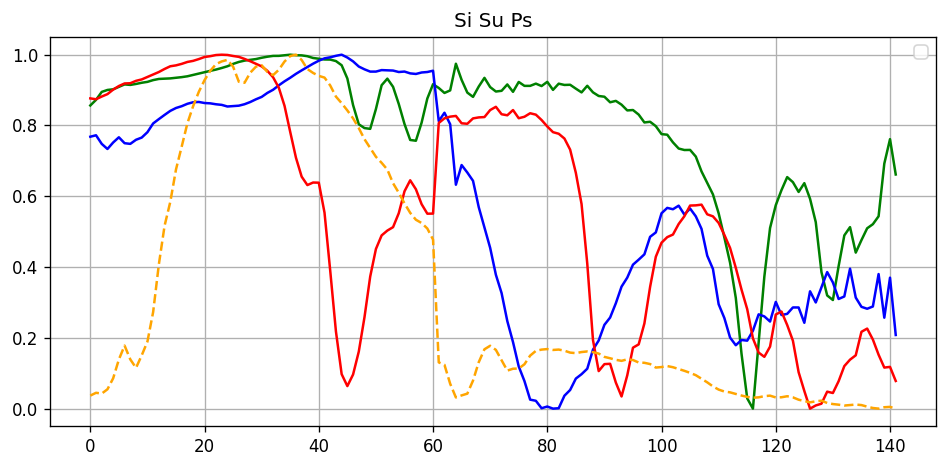

In [ ]:
mean_cube = data["cube"].mean(axis=(0, 1))
mean_cube_win = mean_cube[data["window"]]
norm_trace = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)
correct = lambda x, H : norm_trace(x/(H+1e-8))
mean_cube_norm = norm_trace(mean_cube)
mean_cube_win_norm = norm_trace(mean_cube_win)

Si, Sugar, PS = data["Si"], data["Sugar"], data["PS"]

plt.figure(figsize=(8, 4))
x = np.arange(Si.shape[0])
plt.plot(x,norm_trace(Si), color="green")
plt.plot(x,norm_trace(Sugar), color="blue")
plt.plot(x, norm_trace(PS), color="red")
plt.plot(x, mean_cube_win_norm , color="orange", linestyle="--")
plt.title("Si Su Ps")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### RUN NETWORK

Loading saved model from /content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_recon.pth
Using: None
Loading saved model from /content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_cls.pth

Evaluating model...
Saved predictions NPZ: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_predictions.npz


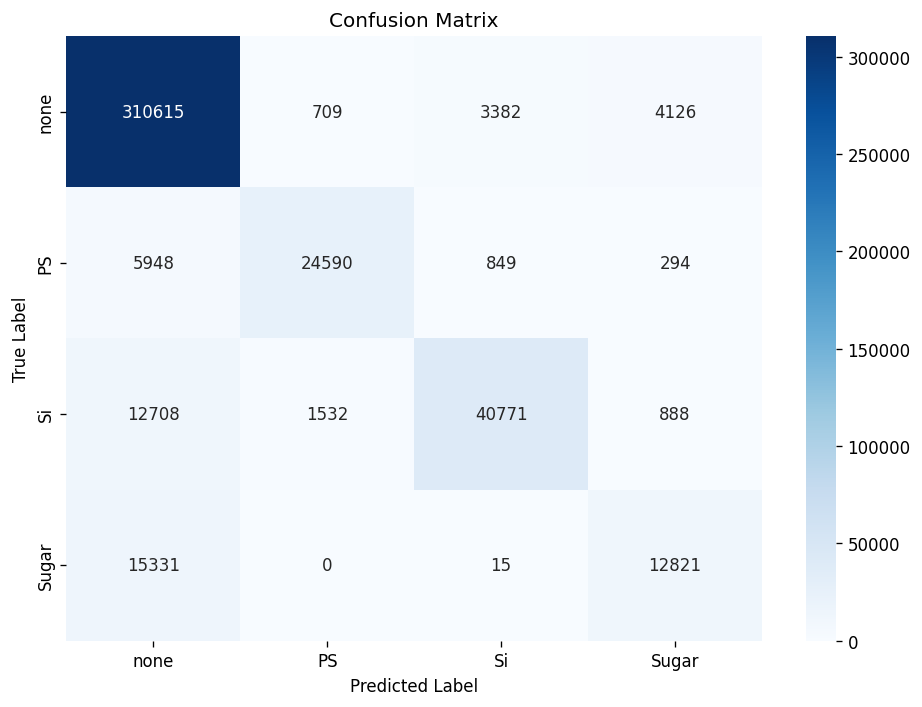

Classification report:
              precision    recall  f1-score   support

        none       0.90      0.97      0.94    318832
          PS       0.92      0.78      0.84     31681
          Si       0.91      0.73      0.81     55899
       Sugar       0.71      0.46      0.55     28167

    accuracy                           0.89    434579
   macro avg       0.86      0.73      0.78    434579
weighted avg       0.89      0.89      0.89    434579

Raw Pixel Accuracy = 0.8947
Non-clean Pixel Accuracy = 0.6755


In [ ]:
results = run_single_experiment(
      data,
      model_path=MODEL_PATH,
      out_prefix=OUT_PREFIX,
      load_if_exists=LOAD_MODEL_SAVED,
      do_save_npz=True # save recon for test traces
  )

### SHOW RECON

Saved reconstructions NPZ: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_reconstructions.npz

=== Examples for true meta=1 ===
  -> idx 283554, pred=1


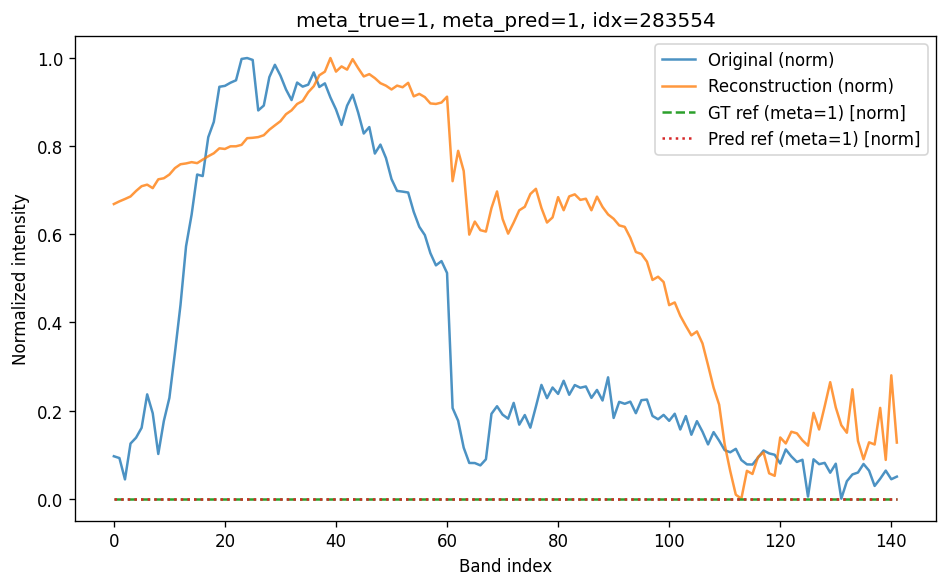

  -> idx 130350, pred=1


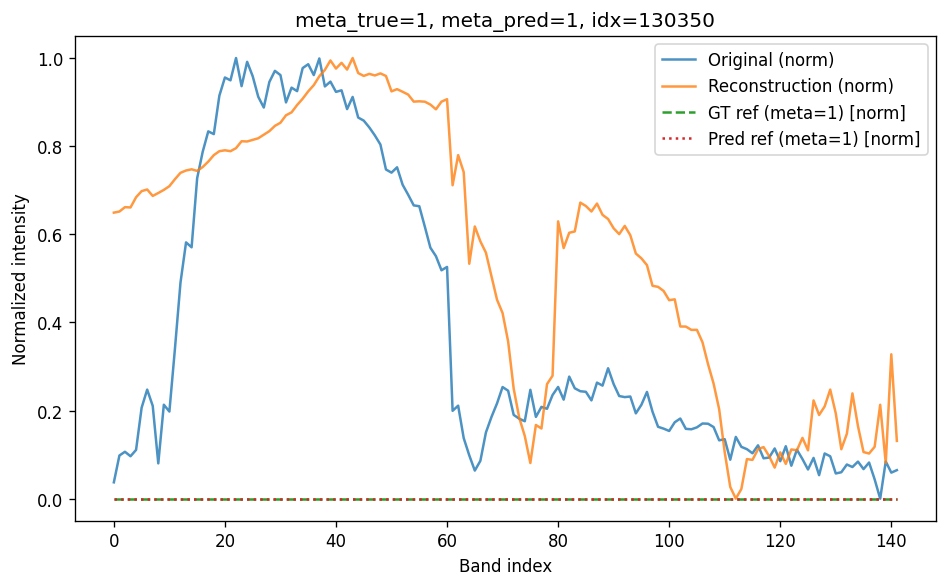


=== Examples for true meta=2 ===
  -> idx 98423, pred=2


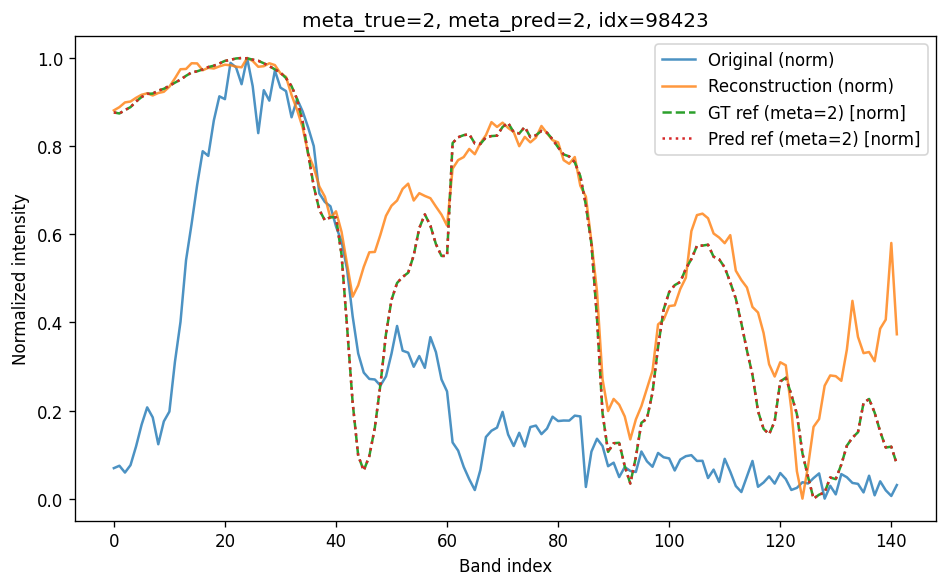

  -> idx 4707, pred=2


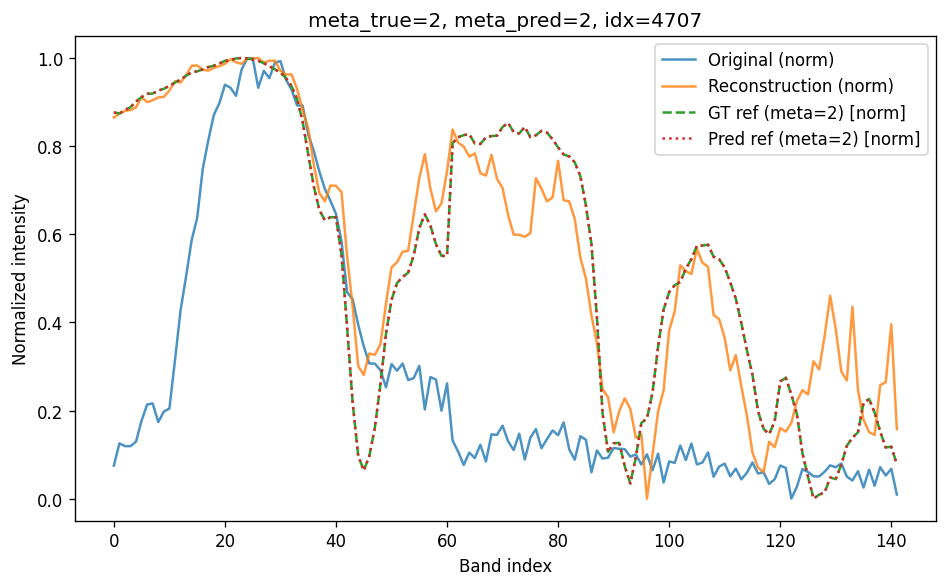


=== Examples for true meta=3 ===
  -> idx 20418, pred=3


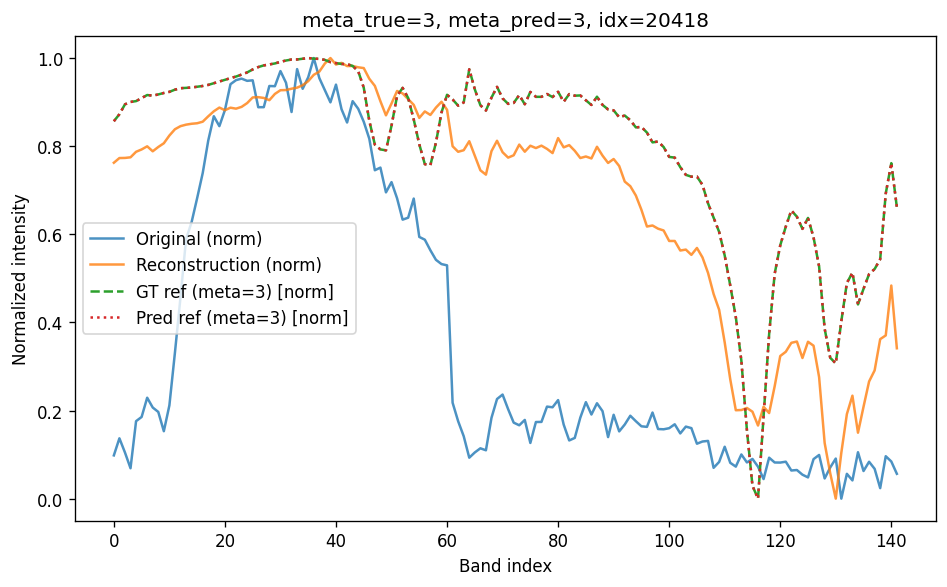

  -> idx 57573, pred=3


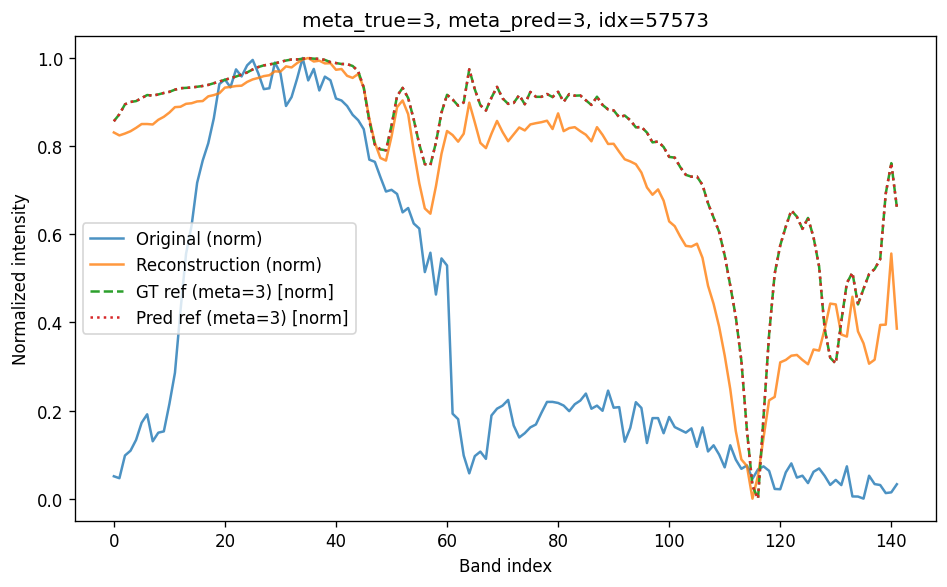


=== Examples for true meta=4 ===
  -> idx 8436, pred=4


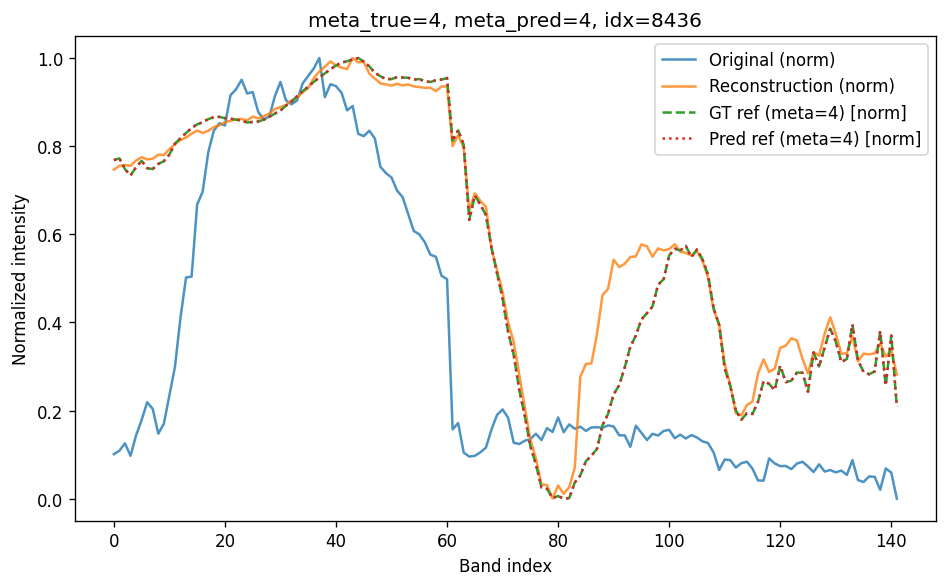

  -> idx 77401, pred=1


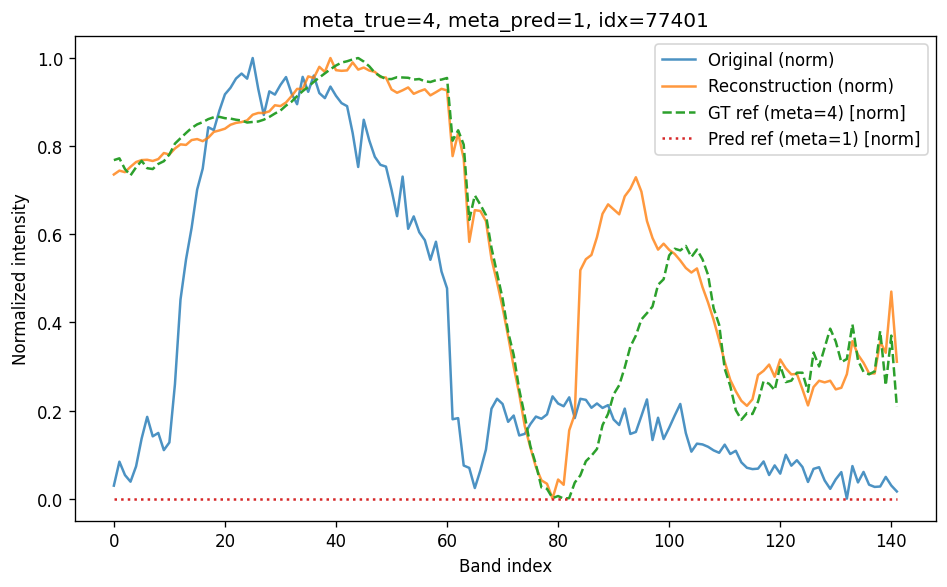

In [ ]:
save_reconstruction_npz(OUT_PREFIX, data, results)
show_reconstruction_examples_per_class(data, results, n_per_class=2, random_state=23)

### SHOW PLOTS

Using: None
Saving RAW pixel prediction color map..


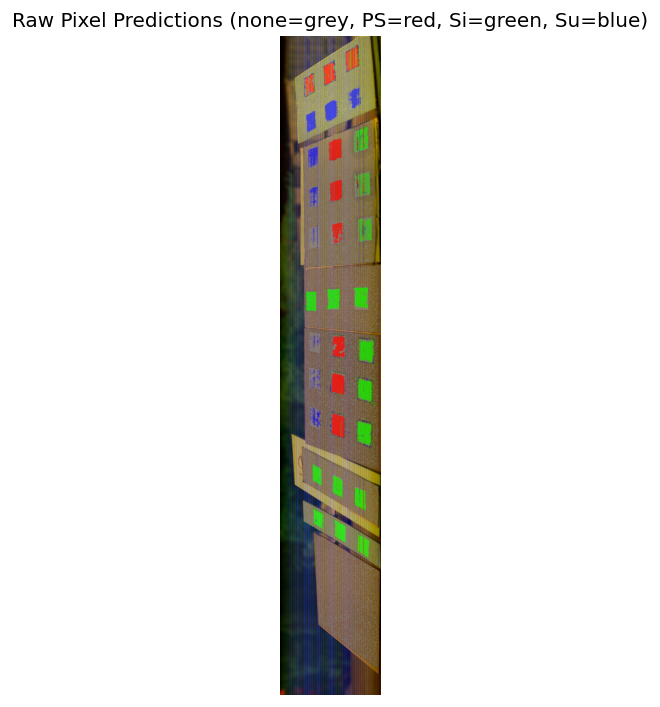

Saved raw pixel prediction map: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_raw_pixel_predictions.png
Saving RAW pixel correctness map...


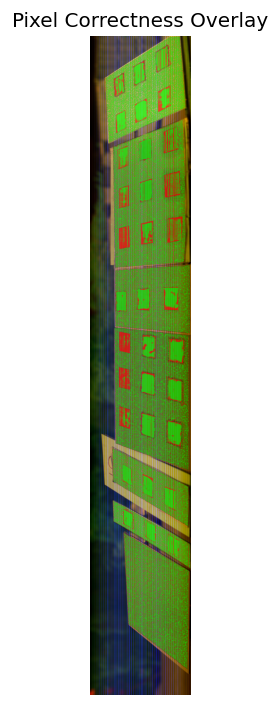

Saved pixel correctness overlay: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_pixel_correctness.png
Saving smoothing before/after visualization...
Finding Block Dominant class...
Saving before/after visualization...


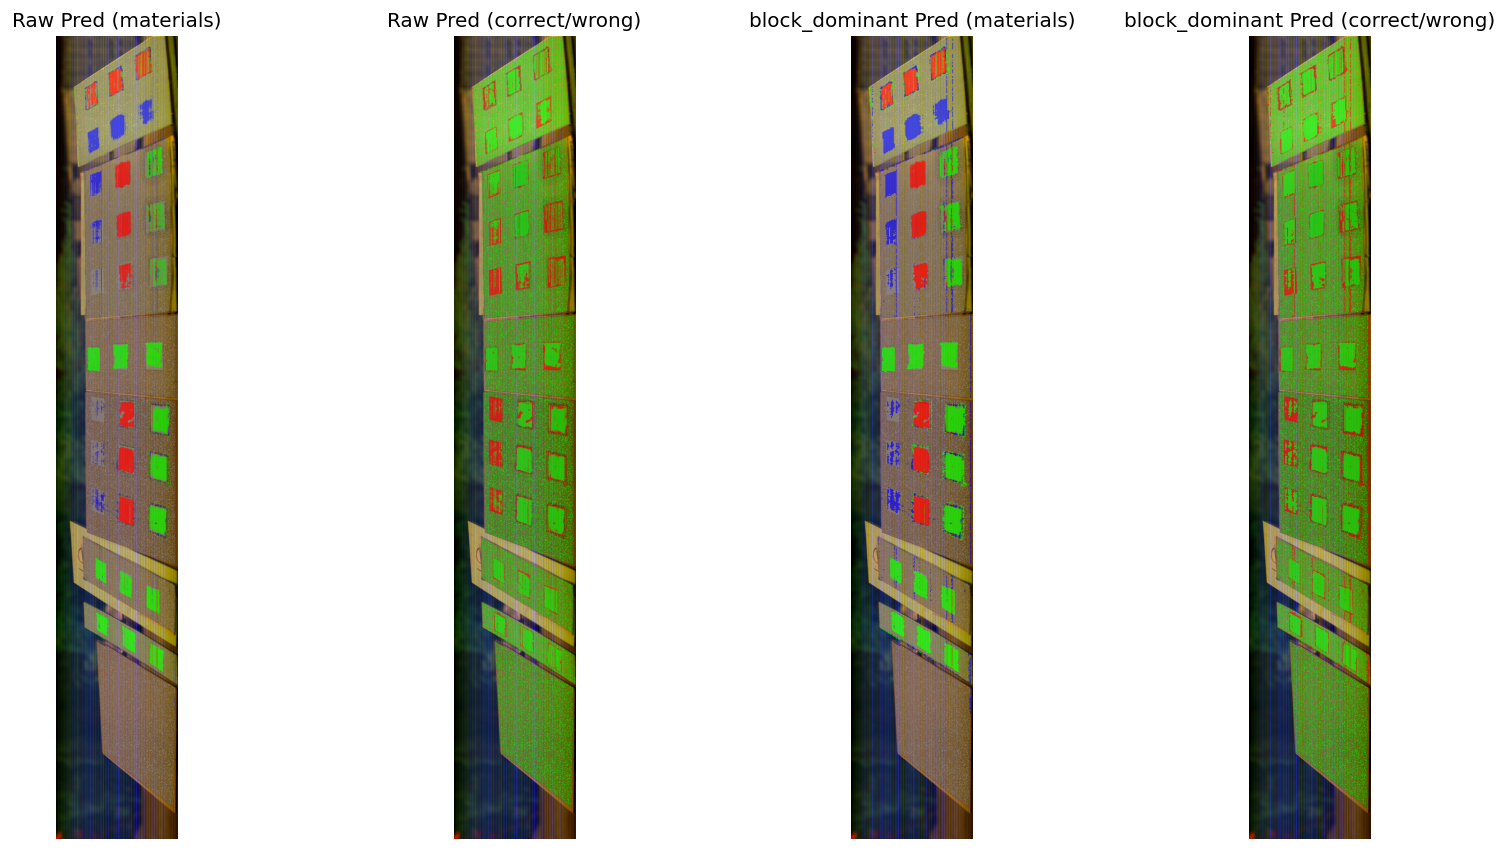

Saved smoothing visualization: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_block_dominant.png
Applay Smooth ...
Saving smoothing before/after visualization...


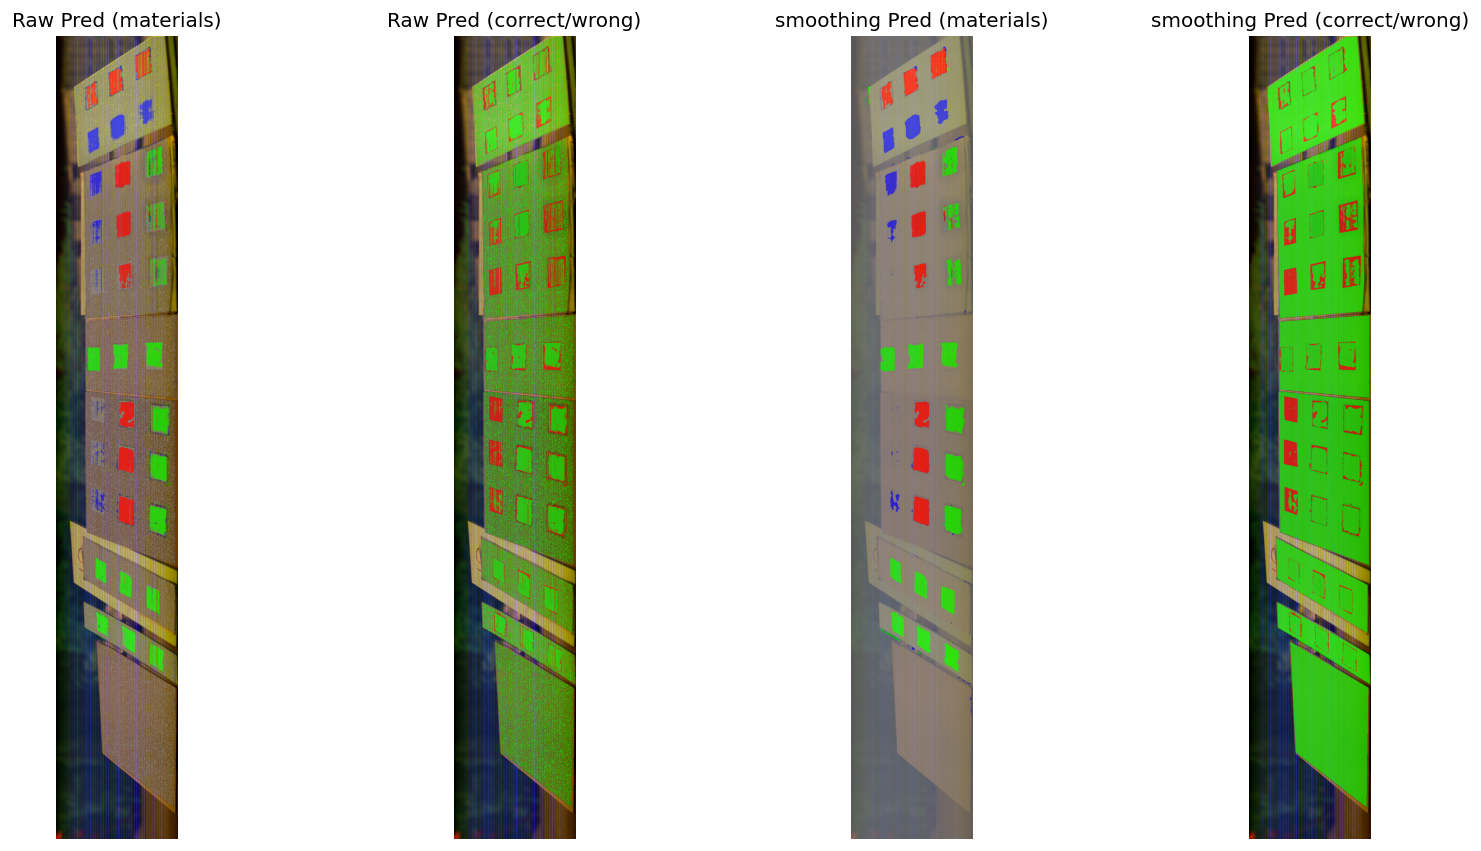

Saved smoothing visualization: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_smoothing.png
Saving polygon correctness map...


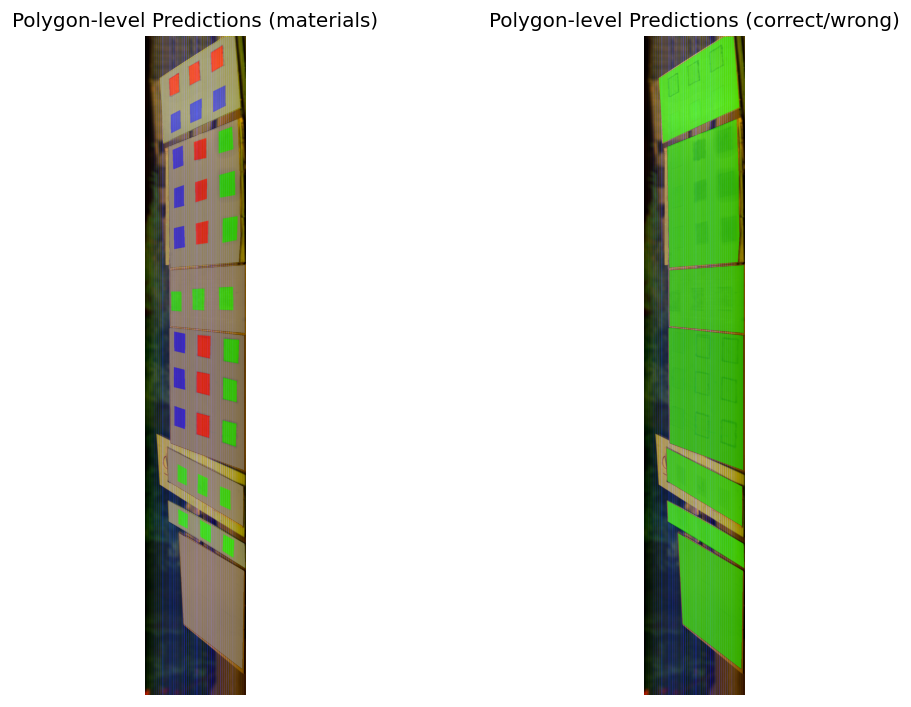

Saved polygon smooth overlay: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_polygon_smooth.png
Saving ROC curves...
Saving ROC per material...


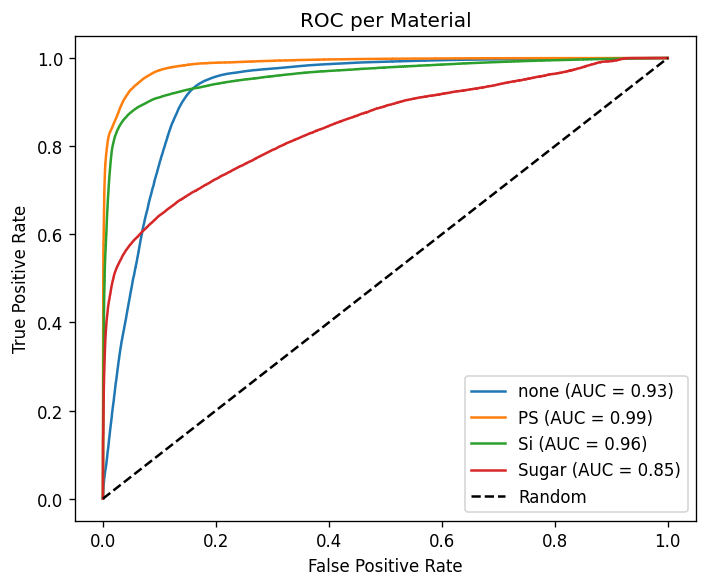

Saved ROC curves: /content/drive/MyDrive/HSI/data/cube_ziv/Standart_2017-10-16_08-32-58_ReconClsNet_ROC.png
Smoothed pixel accuracy...
Smoothed Pixel Accuracy = 0.9164
Polygon classification...
Polygon Accuracy = 1.0000
Accuracy RAW: 0.8946520655623028
Accuracy K_SMOOTH: 0.9164064531420064
Accuracy POLY: 1.0


In [ ]:
post = run_postprocessing(data, results, out_prefix=OUT_PREFIX)
print(f"Accuracy RAW: {results['acc_raw']}")
print(f"Accuracy K_SMOOTH: {post['acc_smooth']}")
print(f"Accuracy POLY: {post['acc_poly']}")

# Infrence

run this cells and change  the cube name

assume cube under \<base>/\<data> path

In [67]:
CUBE_NAME = "08-35-10"
CUBE_PATH  = rf"{DATA_DIR}/{CUBE_NAME}"
HDR_PATH   = rf"{CUBE_PATH}/Standart_2017-10-16_{CUBE_NAME}.hdr"
REF_CSV_PATH = rf"{DATA_DIR}/Ref.csv"

CACHE_DIR = rf"{CUBE_PATH}/dataset_cache"
GT_PATH    = HDR_PATH.replace(".hdr", "_GT.npz")

MODEL_NAME = "ReconClsNet"

# Recon model
LOAD_MODEL_SAVED = True # if True and MODEL_PATH exists, skip training
MODEL_PATH = rf"{CACHE_DIR}/diffusion_model_{MODEL_NAME}.pth"
if LOAD_MODEL_SAVED:
  MODEL_PATH = rf"/content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_recon.pth"

# Cls model
LOAD_CLS_MODEL = True
MODEL_CLS_PATH = None
if LOAD_CLS_MODEL:
  MODEL_CLS_PATH = rf"/content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_cls.pth"

OUT_PREFIX = os.path.splitext(HDR_PATH)[0] + f"_{MODEL_NAME}"
PRED_PATH  = OUT_PREFIX + "_predictions.npz"

# data releted globals
REMOVE_DARK = True
OVERWRITE_FULL_CUBE_TENSOR_PT = True
OVERWRITE_DATASET_CACHE = True
DATA_CACHE_PATH = os.path.join(CACHE_DIR, os.path.basename(os.path.splitext(HDR_PATH)[0])+'_prepared_data.pt')

In [103]:
def prepare_infrence_data(rd = REMOVE_DARK):
    """
    Run once (even for sweeps). Loads cube/GT, builds matrices,
    splits into train/test, and returns everything in a dict.
    """
    print("Loading cube and GT (with cache)...")
    cube_t, wl, meta, cache_path = get_full_cube_tensor(HDR_PATH, overwrite=False, remove_dark=rd)
    cube = cube_t.numpy()
    label_map, _ = load_gt(GT_PATH)
    print(len(wl))
    window = spectral_window_indices(cube.shape[2])
    print(len(window))
    print(wl[window])

    print("Building pixel matrix...")
    M, C, coords = build_mat(cube, label_map, window)

    mean_cube = cube_t.mean(axis=(0, 1))
    norm_trace = lambda x: (x - x.min()) / (x.max() - x.min() + 1e-8)
    mean_cube = norm_trace(mean_cube)

    print("Loading reference curves...")
    Si, Sugar, PS, wl_ref = load_ref(REF_CSV_PATH, wl)
    Si, Sugar, PS = Si[window], Sugar[window], PS[window]

    print("Splitting clean vs contaminated...")
    clean_idx = np.where([reduce_to_meta(id_to_name[cid]) == 1 for cid in C])[0]
    cont_idx  = np.where([reduce_to_meta(id_to_name[cid]) != 1 for cid in C])[0]

    np.random.shuffle(clean_idx)
    cut = 0
    train_clean = M[clean_idx[:cut]]
    test_clean  = M[clean_idx[cut:]]
    print(f"Train clean: {len(train_clean)}")
    print(f"Test clean: {len(test_clean)}")

    bg = train_clean.copy()

    test_real = M[cont_idx]
    test_rm   = np.array([reduce_to_meta(id_to_name[c]) for c in C[cont_idx]])

    test_spectra = np.vstack([test_real, test_clean])
    test_meta    = np.concatenate([test_rm, np.ones(len(test_clean), dtype=int)])

    coords_eval = [coords[i] for i in cont_idx] + [coords[i] for i in clean_idx[cut:]]

    data = {
        "cube": cube,
        "label_map": label_map,
        "coords": coords,
        "window": window,
        "M": M,
        "C": C,
        "Si": Si,
        "Sugar": Sugar,
        "PS": PS,
        "train_clean": train_clean,
        "test_clean": test_clean,
        "bg": bg,
        "test_real": test_real,
        "test_rm": test_rm,
        "test_spectra": test_spectra,
        "test_meta": test_meta,
        "coords_eval": coords_eval,
        "cache_path": cache_path
    }
    return data

In [81]:
data_infrence = prepare_infrence_data()

Loading cube and GT (with cache)...
Reading HDR and caching full cube -> /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_remove_dark_fullcube.pt


/usr/local/lib/python3.12/dist-packages/spectral/io/envi.py:187: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


[SAVED] Cached full cube: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_remove_dark_fullcube.pt
[Dark] Found dark HDR, loading dark cube...
288
142
[1427.59 1433.22 1438.85 1444.47 1450.1  1455.73 1461.35 1466.98 1472.6
 1478.23 1483.85 1489.48 1495.1  1500.72 1506.34 1511.96 1517.59 1523.21
 1528.83 1534.45 1540.07 1545.68 1551.3  1556.92 1562.54 1568.16 1573.77
 1579.39 1585.01 1590.62 1596.24 1601.85 1607.46 1613.08 1618.69 1624.31
 1629.92 1635.53 1641.14 1646.76 1652.37 1657.98 1663.59 1669.2  1674.81
 1680.42 1686.03 1691.64 1697.25 1702.86 1708.46 1714.07 1719.68 1725.29
 1730.9  1736.5  1742.11 1747.72 1753.32 1758.93 1764.53 1988.62 1994.22
 1999.82 2005.42 2011.02 2016.62 2022.22 2027.82 2033.42 2039.02 2044.62
 2050.22 2055.82 2061.42 2067.02 2072.62 2078.22 2083.82 2089.42 2095.02
 2100.62 2106.22 2111.82 2117.42 2123.02 2128.62 2134.22 2139.82 2145.42
 2151.03 2156.63 2162.23 2167.83 2173.43 2179.03 2184.63 2190.23 2195.84
 2201.44 2207.04 2212.64 2

Loading saved model from /content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_recon.pth
Using: None
Loading saved model from /content/drive/MyDrive/HSI/data/cube_ziv/dataset_cache/diffusion_model_MultiTaskNet_20251223_114939_cls.pth

Evaluating model...


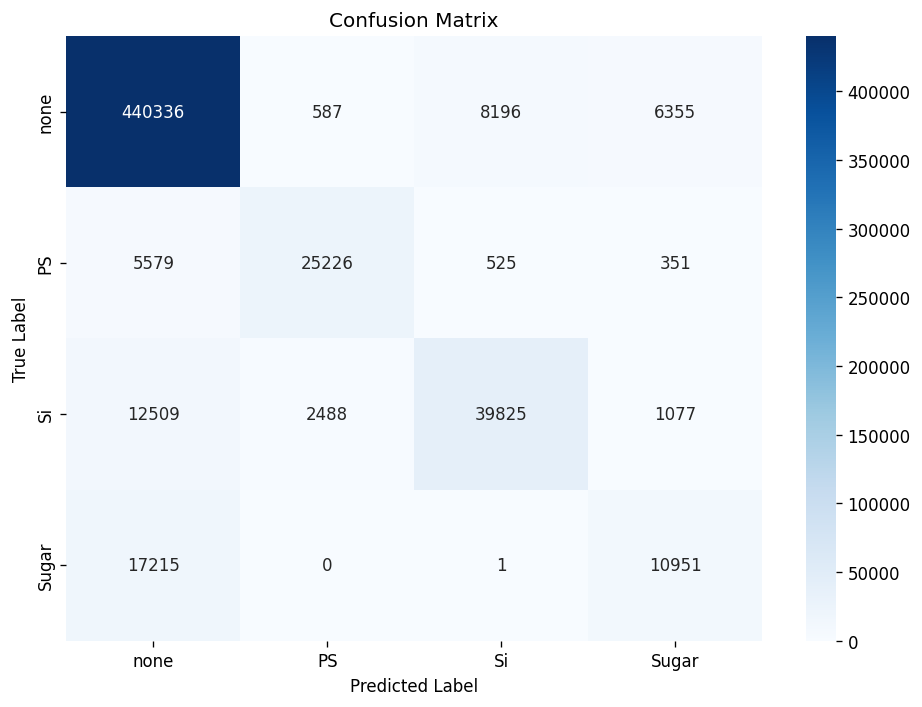

Classification report:
              precision    recall  f1-score   support

        none       0.93      0.97      0.95    455474
          PS       0.89      0.80      0.84     31681
          Si       0.82      0.71      0.76     55899
       Sugar       0.58      0.39      0.47     28167

    accuracy                           0.90    571221
   macro avg       0.81      0.72      0.75    571221
weighted avg       0.90      0.90      0.90    571221

Raw Pixel Accuracy = 0.9039
Non-clean Pixel Accuracy = 0.6566


In [82]:
result_infrences = run_single_experiment(
      data_infrence,
      model_path=MODEL_PATH,
      out_prefix=OUT_PREFIX,
      load_if_exists=LOAD_MODEL_SAVED,
      do_save_npz=False # save recon for test traces
  )

Using: None
Saving RAW pixel prediction color map..


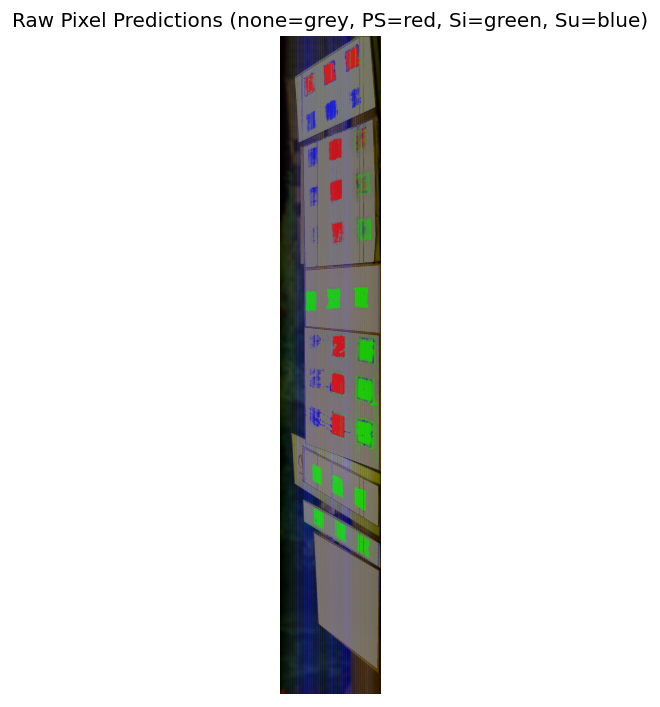

Saved raw pixel prediction map: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_raw_pixel_predictions.png
Saving RAW pixel correctness map...


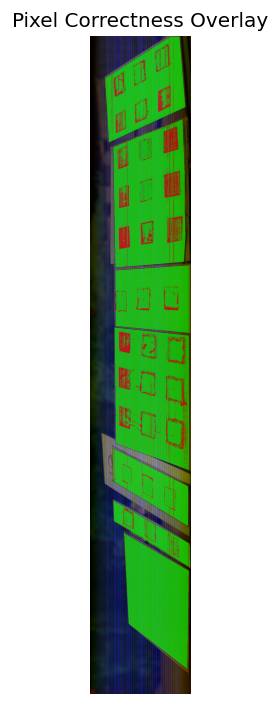

Saved pixel correctness overlay: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_pixel_correctness.png
Saving smoothing before/after visualization...
Finding Block Dominant class...
Saving before/after visualization...


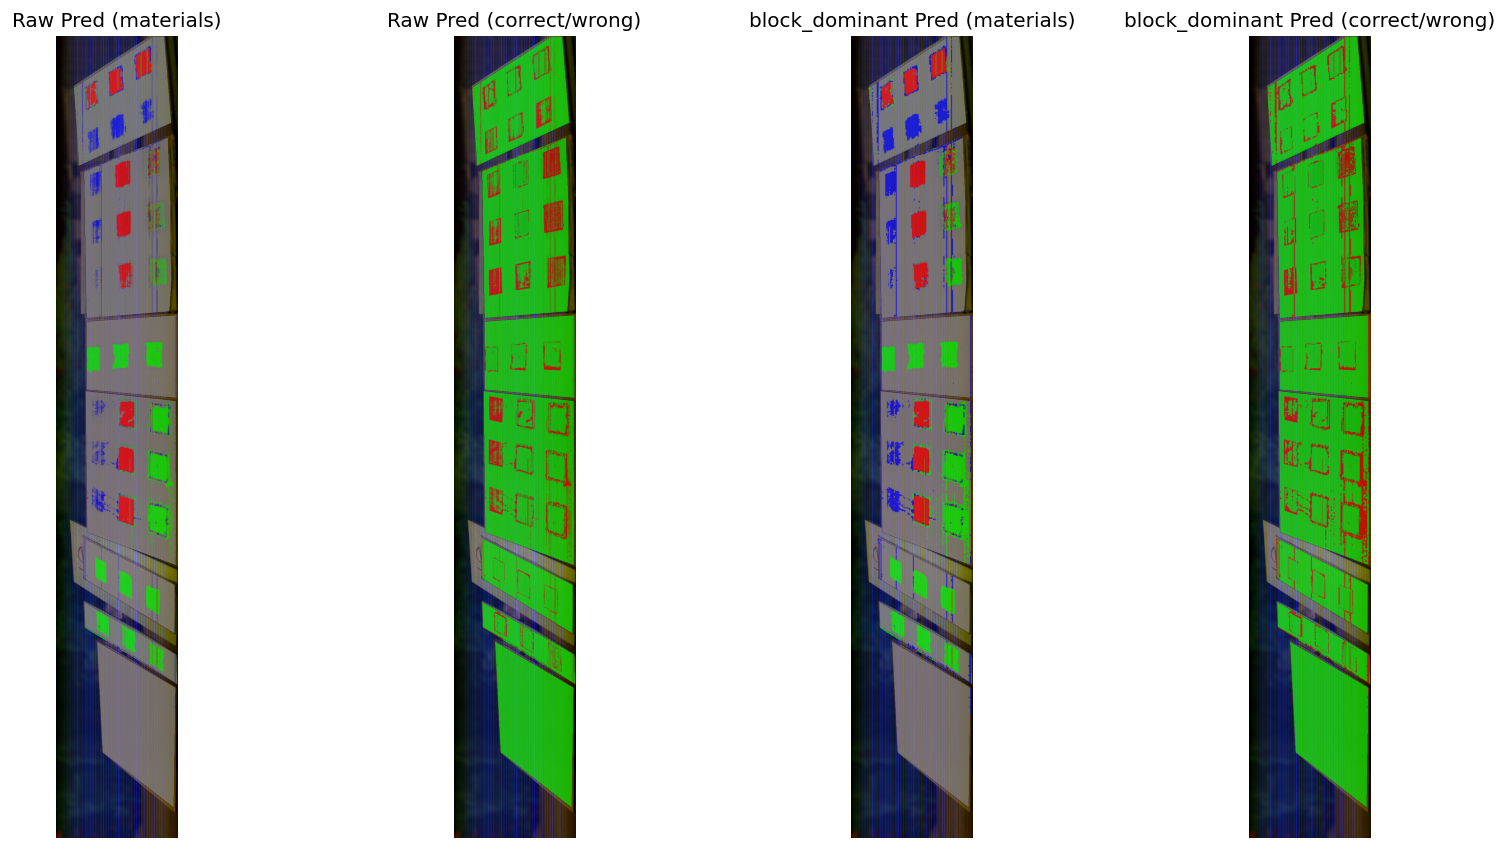

Saved smoothing visualization: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_block_dominant.png
Applay Smooth ...
Saving smoothing before/after visualization...


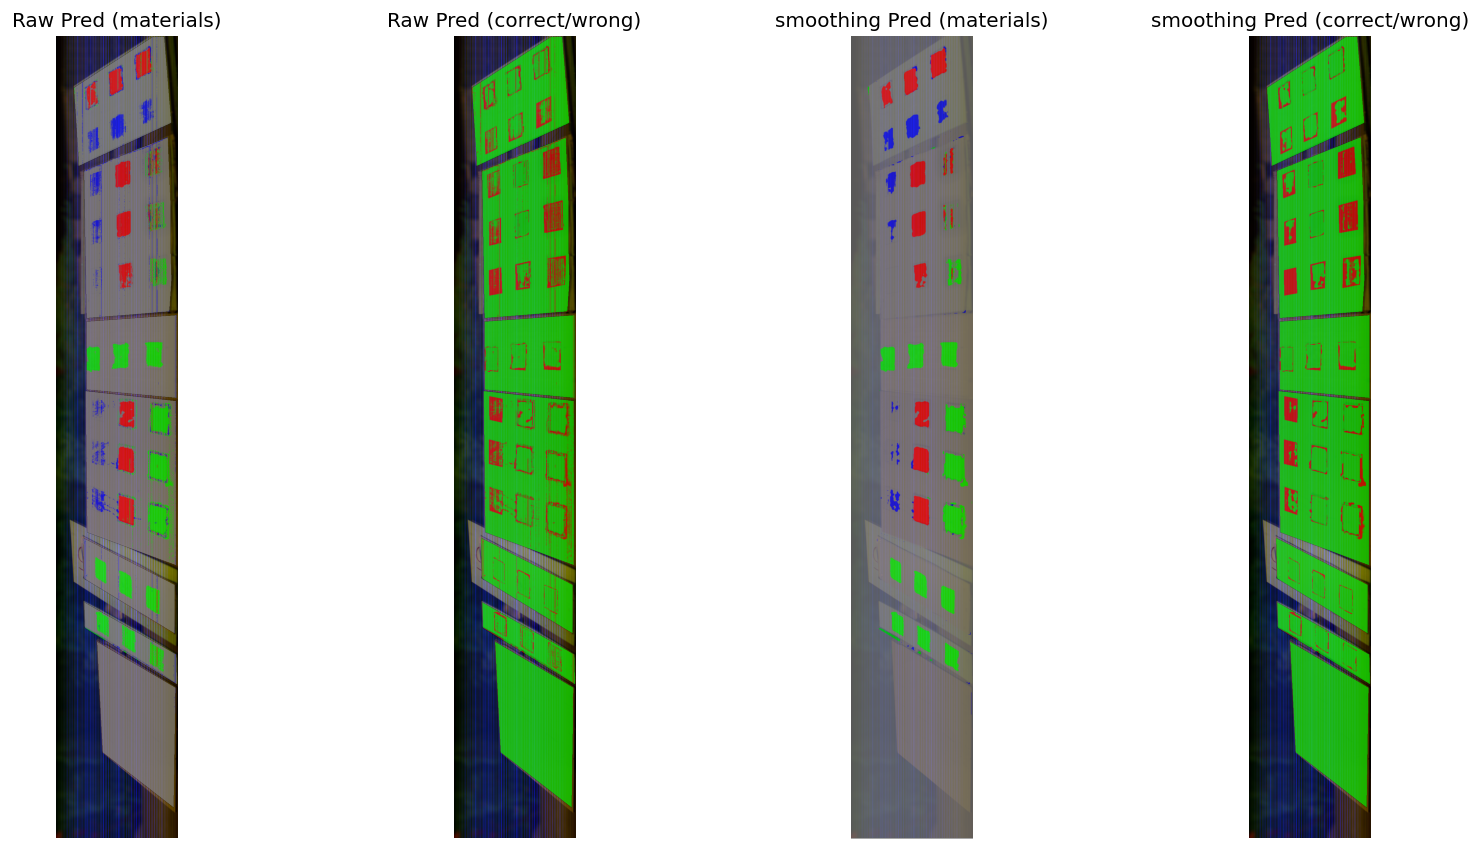

Saved smoothing visualization: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_smoothing.png
Saving polygon correctness map...


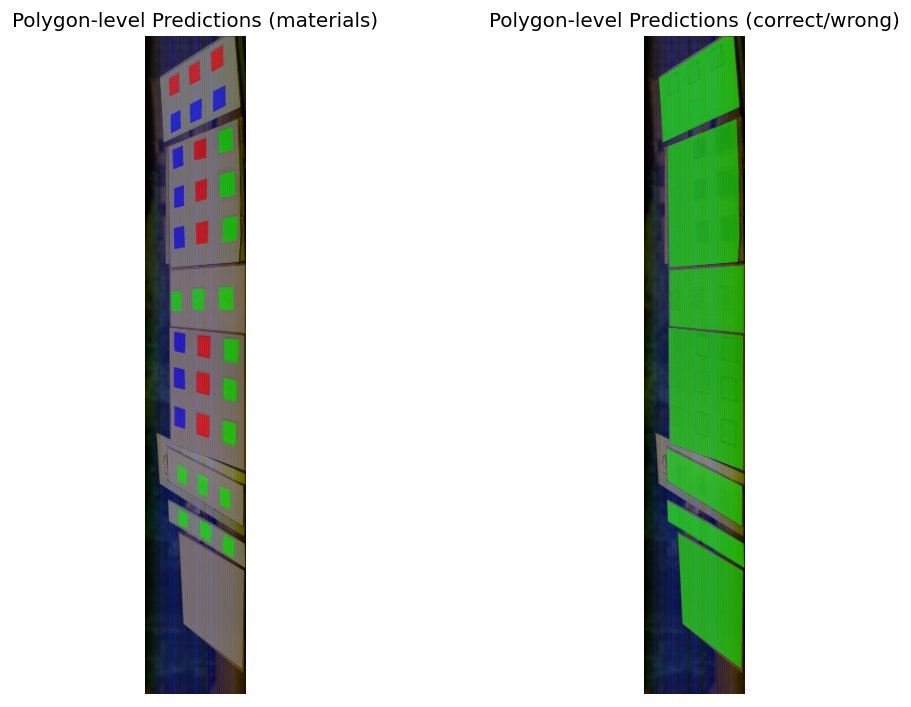

Saved polygon smooth overlay: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_polygon_smooth.png
Saving ROC curves...
Saving ROC per material...


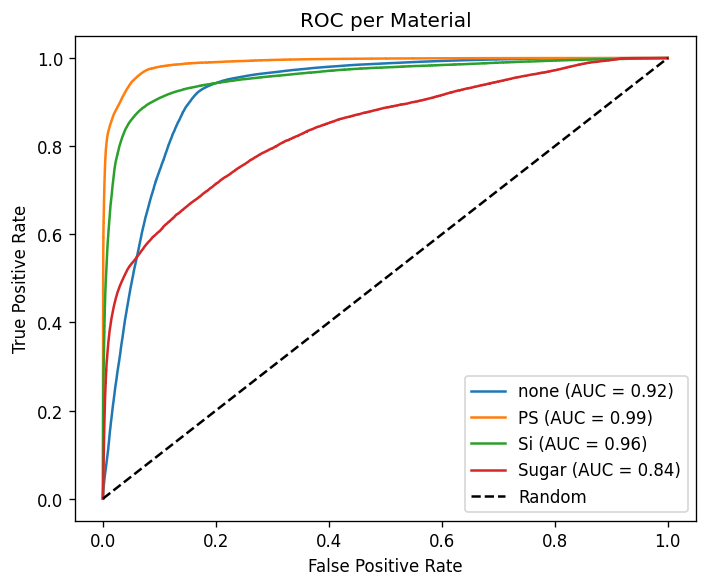

Saved ROC curves: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_ROC.png
Smoothed pixel accuracy...
Smoothed Pixel Accuracy = 0.9204
Polygon classification...
Polygon Accuracy = 1.0000
Accuracy RAW: 0.9039198488851076
Accuracy K_SMOOTH: 0.9204160911451085
Accuracy POLY: 1.0


In [84]:
post_infrences = run_postprocessing(data_infrence, result_infrences, out_prefix=OUT_PREFIX)
print(f"Accuracy RAW: {result_infrences['acc_raw']}")
print(f"Accuracy K_SMOOTH: {post_infrences['acc_smooth']}")
print(f"Accuracy POLY: {post_infrences['acc_poly']}")

---
# Cross Correlation
---

###  baseline

In [85]:
def apply_local_background_removal(cube: np.ndarray,
                                   coords_eval,
                                   LBR: int,
                                   device: str = DEVICE) -> np.ndarray:
    """
    Apply Local Background Removal (LBR) to the cube and return corrected
    spectra only at coords_eval.

    For each pixel, we subtract the local mean spectrum in an LBR x LBR window
    (computed per wavelength band).

    Args
    ----
    cube : np.ndarray, shape [H, W, B]
        Hyperspectral cube.
    coords_eval : list[(r,c)]
        Coordinates of pixels that form the test_spectra in order.
    LBR : int
        Window size (e.g., 5 => 5x5). If <= 1, no LBR is applied.
    device : str
        PyTorch device.

    Returns
    -------
    spectra_lbr : np.ndarray, shape [len(coords_eval), B]
        LBR-corrected spectra in the same order as coords_eval.
    """
    if LBR is None or LBR <= 1:
        # No LBR: just return original spectra
        H, W, B = cube.shape
        spectra = np.zeros((len(coords_eval), B), dtype=np.float32)
        for i, (r, c) in enumerate(coords_eval):
            spectra[i] = cube[r, c, :]
        return spectra

    H, W, B = cube.shape

    # Cap window size so it doesn't exceed image dimensions and keep it odd
    k = min(LBR, H, W)
    if k % 2 == 0:
        k -= 1
    k = max(k, 3)
    pad = k // 2

    # Convert cube to torch: [1, B, H, W]
    cube_t = torch.tensor(cube, dtype=torch.float32, device=device)  # [H,W,B]
    cube_t = cube_t.permute(2, 0, 1).unsqueeze(0)  # [1,B,H,W]

    # Uniform kernel per band: each band has its own filter (groups=B)
    kernel = torch.ones((B, 1, k, k), device=device) / (k * k)

    # Local mean per band via grouped conv2d
    bg = F.conv2d(cube_t, kernel, padding=pad, groups=B)  # [1,B,H,W]
    bg = bg.squeeze(0).permute(1, 2, 0)  # [H,W,B]

    # Subtract local background
    cube_lbr = cube_t.squeeze(0).permute(1, 2, 0) - bg  # [H,W,B] on device
    cube_lbr = cube_lbr.detach().cpu().numpy()

    # Extract spectra at coords_eval in correct order
    spectra_lbr = np.zeros((len(coords_eval), B), dtype=np.float32)
    for i, (r, c) in enumerate(coords_eval):
        spectra_lbr[i] = cube_lbr[r, c, :]

    return spectra_lbr


In [87]:
import torch.nn.functional as F  # make sure this is imported once at top

def evaluate_reference_xcorr(
    test_spectra: np.ndarray,
    ref_ps: np.ndarray,
    ref_si: np.ndarray,
    ref_su: np.ndarray,
    diff_thresh: float = 0.15,
    sigma_smooth: float = 0.0,
    device: str = DEVICE,
):
    """
    Baseline 'model' that uses cross-correlation (dot product on normalized
    spectra) with the 3 reference signatures (PS, Si, Su).

    Optional Gaussian smoothing is applied along the spectral axis to reduce noise.

    Steps for each test spectrum:
      0) (Optional) Gaussian smooth with std = sigma_smooth
      1) Per-spectrum min-max normalize to [0, 1]
      2) Compute dot product with each reference
      3) Softmax over the 3 scores -> material probabilities
      4) Use materials_uncertain() to decide:
           - if certain -> choose argmax material (PS/Si/Su)
           - if uncertain -> choose none

    Parameters
    ----------
    sigma_smooth : float
        Standard deviation of the Gaussian kernel used to smooth each spectrum.
        If <= 0, no smoothing is applied.

    Returns
    -------
    preds_meta : np.ndarray, shape [N]
        Predicted meta labels: 1=none, 2=PS, 3=Si, 4=Su
    probs_mat  : np.ndarray, shape [N,3]
        Softmax probabilities over [PS, Si, Su].
    scores_mat : np.ndarray, shape [N,3]
        Raw correlation scores (dot products) before softmax, columns = [PS, Si, Su].
    mat_uncertain : np.ndarray, shape [N], bool
        True where materials_uncertain(...) flagged ambiguity (these became 'none').
    """
    # Move data to torch
    x = torch.tensor(test_spectra, dtype=torch.float32, device=device)  # [N,B]
    N, B = x.shape

    # -------------------------------------------------
    # (0) Optional Gaussian smoothing along spectral axis
    # -------------------------------------------------
    if sigma_smooth is not None and sigma_smooth > 0.0:
        # Build 1D Gaussian kernel
        kernel_size = int(6 * sigma_smooth + 1)
        if kernel_size % 2 == 0:
            kernel_size += 1

        # Cap kernel size to spectrum length (and keep it >= 3)
        if kernel_size > B:
            kernel_size = B if B % 2 == 1 else B - 1
        kernel_size = max(kernel_size, 3)

        half = kernel_size // 2

        xs = torch.arange(kernel_size, device=device) - half
        kernel = torch.exp(-0.5 * (xs / sigma_smooth) ** 2)
        kernel = kernel / kernel.sum()
        kernel = kernel.view(1, 1, -1)  # [out_channels=1, in_channels=1, K]

        # reshape to [N,1,B] and use conv1d padding instead of F.pad
        x_ = x.unsqueeze(1)  # [N,1,B]
        x_smooth = F.conv1d(x_, kernel, padding=half)  # zero-padding
        x = x_smooth.squeeze(1)  # back to [N,B]

    # -------------------------------------------------
    # (1) Per-spectrum min-max normalization
    # -------------------------------------------------
    x_min = x.min(dim=1, keepdim=True).values
    x_max = x.max(dim=1, keepdim=True).values
    x_norm = (x - x_min) / (x_max - x_min + 1e-8)  # [N, B]

    # -------------------------------------------------
    # (2) Reference signatures (kept as-is here)
    # -------------------------------------------------
    ref_ps_t = torch.tensor(ref_ps, dtype=torch.float32, device=device)
    ref_si_t = torch.tensor(ref_si, dtype=torch.float32, device=device)
    ref_su_t = torch.tensor(ref_su, dtype=torch.float32, device=device)

    def norm_ref(r):
        # You currently use raw ref spectra; keep that behavior
        return r

    ref_ps_n = norm_ref(ref_ps_t)  # [B]
    ref_si_n = norm_ref(ref_si_t)
    ref_su_n = norm_ref(ref_su_t)

    # -------------------------------------------------
    # (3) Dot products as correlation scores
    # -------------------------------------------------
    scores_ps = (x_norm * ref_ps_n.unsqueeze(0)).sum(dim=1)  # [N]
    scores_si = (x_norm * ref_si_n.unsqueeze(0)).sum(dim=1)
    scores_su = (x_norm * ref_su_n.unsqueeze(0)).sum(dim=1)

    scores = torch.stack([scores_ps, scores_si, scores_su], dim=1)  # [N, 3]

    # Softmax over materials
    probs_mat = torch.softmax(scores, dim=1)  # [N,3]

    # Uncertainty decision (on PS/Si/Su probs)
    mat_uncertain = materials_uncertain(probs_mat, diff_thresh=diff_thresh)  # [N] bool

    # Base material prediction: argmax over 3 -> indices 0..2
    top_idx = torch.argmax(probs_mat, dim=1)  # 0=PS, 1=Si, 2=Su

    # Map to meta labels: 2=PS, 3=Si, 4=Su
    preds_meta = top_idx + 2  # 2..4, torch tensor

    # For uncertain ones -> choose none (1)
    preds_meta[mat_uncertain] = 1

    preds_meta_np    = preds_meta.cpu().numpy()
    probs_mat_np     = probs_mat.cpu().numpy()
    scores_mat_np    = scores.cpu().numpy()
    mat_uncertain_np = mat_uncertain.cpu().numpy()

    return preds_meta_np, probs_mat_np, scores_mat_np, mat_uncertain_np


### Visualization

In [88]:
def plot_xcorr_scene_maps(
    data: dict,
    scores_mat: np.ndarray,      # [N,3] scores for [PS, Si, Su]
    mat_uncertain: np.ndarray,   # [N] bool, True where we chose 'none'
    out_prefix: str,
):
    """
    Plot 4 images of the scene:
      1) Heatmap of correlation with PS over the scene
      2) Heatmap of correlation with Si
      3) Heatmap of correlation with Su
      4) Heatmap of 'uncertain/none' decisions

    Overlays each heatmap on top of the RGB scene.
    """
    label_map   = data["label_map"]
    coords_eval = data["coords_eval"]
    cube        = data["cube"]

    H, W = label_map.shape
    N = len(coords_eval)

    assert scores_mat.shape[0] == N, "scores_mat and coords_eval length mismatch"
    assert scores_mat.shape[1] == 3, "scores_mat must have 3 columns [PS, Si, Su]"
    assert mat_uncertain.shape[0] == N, "mat_uncertain and coords_eval length mismatch"

    # Build RGB image
    rgb = cube[:, :, [120, 42, 0]].astype(float)
    for i in range(3):
        m = rgb[:, :, i].max()
        if m > 0:
            rgb[:, :, i] /= m
    rgb_disp = rgb

    # Initialize maps with NaN to distinguish non-evaluated pixels
    map_ps  = np.full((H, W), np.nan, dtype=float)
    map_si  = np.full((H, W), np.nan, dtype=float)
    map_su  = np.full((H, W), np.nan, dtype=float)
    map_unc = np.full((H, W), np.nan, dtype=float)

    # Fill maps at evaluated coordinates
    for i, (r, c) in enumerate(coords_eval):
        map_ps[r, c]  = scores_mat[i, 0]          # PS score
        map_si[r, c]  = scores_mat[i, 1]          # Si score
        map_su[r, c]  = scores_mat[i, 2]          # Su score
        map_unc[r, c] = 1.0 if mat_uncertain[i] else 0.0  # 1 = uncertain/none, 0 = confident

    # Helper: normalize map to [0,1] ignoring NaNs
    def normalize_map(m):
        out = m.copy()
        mask = ~np.isnan(out)
        if mask.any():
            vals = out[mask]
            lo, hi = vals.min(), vals.max()
            if hi > lo:
                out[mask] = (vals - lo) / (hi - lo)
            else:
                out[mask] = 0.0
        out[~mask] = 0.0
        return out

    map_ps_n  = normalize_map(map_ps)
    map_si_n  = normalize_map(map_si)
    map_su_n  = normalize_map(map_su)
    map_unc_n = normalize_map(map_unc)

    # Plot 2x2 grid: PS, Si, Su, uncertainty
    fig, axes = plt.subplots(1, 4, figsize=(12, 5))

    # PS
    ax = axes[0]
    ax.imshow(rgb_disp)
    im0 = ax.imshow(map_ps_n, cmap="viridis", alpha=0.7)
    ax.set_title("Cross-correlation with PS")
    ax.axis("off")
    fig.colorbar(im0, ax=ax, fraction=0.046, pad=0.04)

    # Si
    ax = axes[1]
    ax.imshow(rgb_disp)
    im1 = ax.imshow(map_si_n, cmap="viridis", alpha=0.7)
    ax.set_title("Cross-correlation with Si")
    ax.axis("off")
    fig.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)

    # Su
    ax = axes[2]
    ax.imshow(rgb_disp)
    im2 = ax.imshow(map_su_n, cmap="viridis", alpha=0.7)
    ax.set_title("Cross-correlation with Su")
    ax.axis("off")
    fig.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)

    # Uncertainty / 'none'
    ax = axes[3]
    ax.imshow(rgb_disp)
    im3 = ax.imshow(map_unc_n, cmap="magma", alpha=0.7)
    ax.set_title("Uncertainty map (1 = chose none)")
    ax.axis("off")
    fig.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)

    fig.tight_layout()
    png_path = out_prefix + "_xcorr_maps.png"
    plt.savefig(png_path, dpi=200)
    plt.show(fig)
    print(f"Saved cross-correlation scene maps: {png_path}")


### Full reference pipeline

In [89]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_reference_baseline(
    data: dict,
    diff_thresh: float = 0.15,
    sigma_smooth: float = 0.0,
    LBR: int = 0,
    debug=True,
    out_prefix: str | None = None,
):
    """
    Run the cross-correlation baseline on the test set and call the
    standard visualization pipeline (smoothing, polygon accuracy, overlays).

    Args
    ----
    data : dict
        Output of prepare_data(), must contain:
          - "test_spectra", "test_meta"
          - "Si", "Sugar", "PS"
          - "label_map", "coords_eval", "cube"
    diff_thresh : float
        Threshold for materials_uncertain().
    out_prefix : str or None
        Prefix for saved figures/files. If None, uses OUT_PREFIX + "_xcorr_ref".
    """
    if out_prefix is None:
        out_prefix = OUT_PREFIX + "_xcorr_ref"

    test_spectra = data["test_spectra"]  # [N, Bwin]
    test_meta    = data["test_meta"]     # [N]
    Si           = data["Si"]
    Sugar        = data["Sugar"]
    PS           = data["PS"]
    label_map    = data["label_map"]
    coords_eval  = data["coords_eval"]
    cube         = data["cube"]          # [H,W,B-all] full cube
    window       = data.get("window", None)  # band indices used to build M/PS/Si/Sugar

    if debug:
      print("\n[XCORR BASELINE] Evaluating reference cross-correlation model...")
      print(f"  LBR window = {LBR}, sigma_smooth = {sigma_smooth}")

    # -------------------------------------------------
    # 1) Local Background Removal (LBR) in the spatial domain
    # -------------------------------------------------
    if LBR is not None and LBR > 1:
        if debug:
          print(f"Applying Local Background Removal with window {LBR}x{LBR}...")
        # This returns spectra over ALL cube bands
        test_spectra_lbr_full = apply_local_background_removal(
            cube=cube,
            coords_eval=coords_eval,
            LBR=LBR,
            device=DEVICE,
        )

        # IMPORTANT: re-apply the same spectral window we used for M/PS/Si/Su
        if window is not None:
            test_spectra_lbr = test_spectra_lbr_full[:, window]
        else:
            # Fallback: if no window in data, enforce same band count as refs
            B_ref = len(PS)
            if test_spectra_lbr_full.shape[1] != B_ref:
                raise ValueError(
                    f"LBR spectra bands ({test_spectra_lbr_full.shape[1]}) "
                    f"!= ref bands ({B_ref}) and no 'window' in data."
                )
            test_spectra_lbr = test_spectra_lbr_full
    else:
        # No LBR: just use the already-windowed test_spectra
        test_spectra_lbr = test_spectra

    # Sanity check: bands must match reference length
    if test_spectra_lbr.shape[1] != len(PS):
        raise ValueError(
            f"test_spectra_lbr has {test_spectra_lbr.shape[1]} bands, "
            f"but PS has {len(PS)}. They must match."
        )

    # -------------------------------------------------
    # 2) Cross-correlation baseline (with optional spectral smoothing)
    # -------------------------------------------------

    # Cross-correlation baseline predictions
    preds_meta, probs_mat, scores_mat, mat_uncertain = evaluate_reference_xcorr(
        test_spectra=test_spectra_lbr,
        ref_ps=PS,
        ref_si=Si,
        ref_su=Sugar,
        diff_thresh=diff_thresh,
        sigma_smooth=sigma_smooth,
        device=DEVICE,
    )

    # Build raw prediction map (same as for the learned model)
    pred_map_raw = np.zeros(label_map.shape, dtype=int)
    for (r, c), p in zip(coords_eval, preds_meta):
        pred_map_raw[r, c] = p

    # Confusion matrix + basic metrics
    if debug:
      cm = confusion_matrix(test_meta, preds_meta)
      plt.figure(figsize=(8, 6))
      sns.heatmap(
          cm,
          annot=True,
          fmt="d",
          cmap="Blues",
          xticklabels=["none", "PS", "Si", "Sugar"],
          yticklabels=["none", "PS", "Si", "Sugar"],
      )
      plt.xlabel("Predicted Label")
      plt.ylabel("True Label")
      plt.title("Confusion Matrix (XCORR baseline)")
      plt.tight_layout()
      cm_path = out_prefix + "_confusion_xcorr.png"
      plt.savefig(cm_path, dpi=200)
      plt.close()
      print(f"Saved baseline confusion matrix: {cm_path}")

      print("Classification report (XCORR baseline):")
      print(
          classification_report(
              test_meta,
              preds_meta,
              target_names=["none", "PS", "Si", "Sugar"],
          )
      )

    acc_raw = float((preds_meta == test_meta).mean())
    if debug:
      print(f"[XCORR BASELINE] Raw Pixel Accuracy = {acc_raw:.4f}")

    # Package results in same structure as model run, but probs_all=None
    results = {
        "acc_raw": acc_raw,
        "preds": preds_meta,
        "pred_map_raw": pred_map_raw,
        "probs_all": None,   # so run_postprocessing will skip ROC
    }

    if debug:
      plot_xcorr_scene_maps(
          data=data,
          scores_mat=scores_mat,
          mat_uncertain=mat_uncertain,
          out_prefix=out_prefix,
      )

    return results


## Cross Correlation - PLOTS

In [112]:
cc_data = prepare_infrence_data(rd = True)

Loading cube and GT (with cache)...
Loading cached full cube: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_remove_dark_fullcube.pt
288
142
[1427.59 1433.22 1438.85 1444.47 1450.1  1455.73 1461.35 1466.98 1472.6
 1478.23 1483.85 1489.48 1495.1  1500.72 1506.34 1511.96 1517.59 1523.21
 1528.83 1534.45 1540.07 1545.68 1551.3  1556.92 1562.54 1568.16 1573.77
 1579.39 1585.01 1590.62 1596.24 1601.85 1607.46 1613.08 1618.69 1624.31
 1629.92 1635.53 1641.14 1646.76 1652.37 1657.98 1663.59 1669.2  1674.81
 1680.42 1686.03 1691.64 1697.25 1702.86 1708.46 1714.07 1719.68 1725.29
 1730.9  1736.5  1742.11 1747.72 1753.32 1758.93 1764.53 1988.62 1994.22
 1999.82 2005.42 2011.02 2016.62 2022.22 2027.82 2033.42 2039.02 2044.62
 2050.22 2055.82 2061.42 2067.02 2072.62 2078.22 2083.82 2089.42 2095.02
 2100.62 2106.22 2111.82 2117.42 2123.02 2128.62 2134.22 2139.82 2145.42
 2151.03 2156.63 2162.23 2167.83 2173.43 2179.03 2184.63 2190.23 2195.84
 2201.44 2207.04 2212.64 2218.25 2

Running cross correlation baseline...

[XCORR BASELINE] Evaluating reference cross-correlation model...
  LBR window = 300, sigma_smooth = 2.0
Applying Local Background Removal with window 300x300...
Saved baseline confusion matrix: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_xcorr_ref_confusion_xcorr.png
Classification report (XCORR baseline):
              precision    recall  f1-score   support

        none       0.83      0.96      0.89    455474
          PS       0.65      0.55      0.60     31681
          Si       0.00      0.00      0.00     55899
       Sugar       0.17      0.12      0.14     28167

    accuracy                           0.80    571221
   macro avg       0.41      0.41      0.41    571221
weighted avg       0.71      0.80      0.75    571221

[XCORR BASELINE] Raw Pixel Accuracy = 0.7992


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


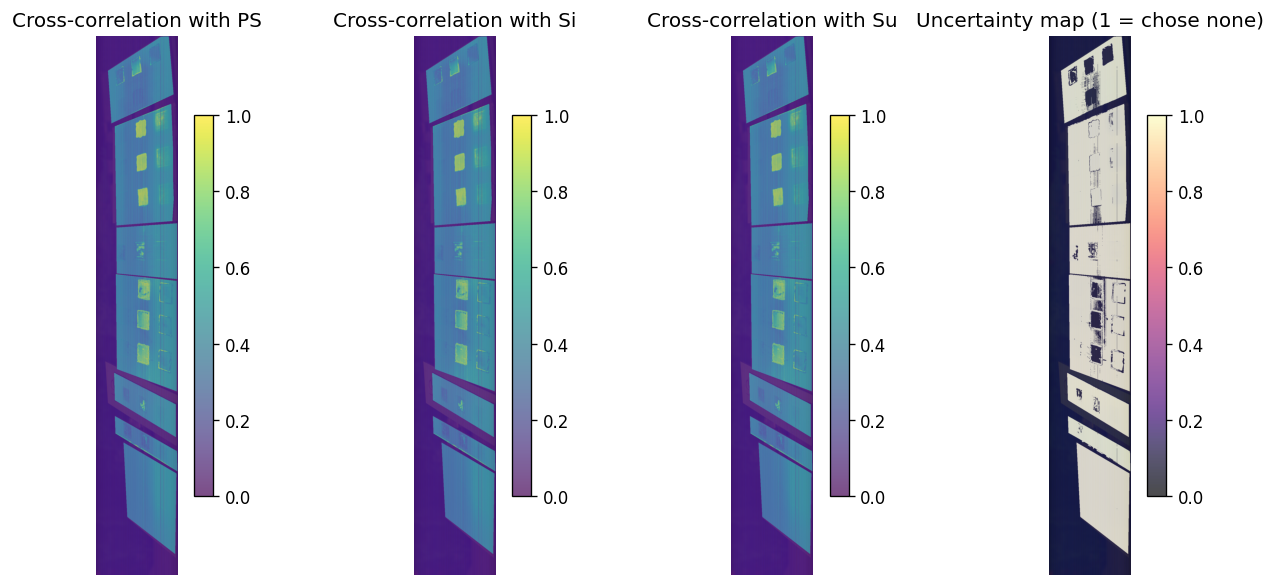

Saved cross-correlation scene maps: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_ReconClsNet_xcorr_ref_xcorr_maps.png
Saving RAW pixel prediction color map..


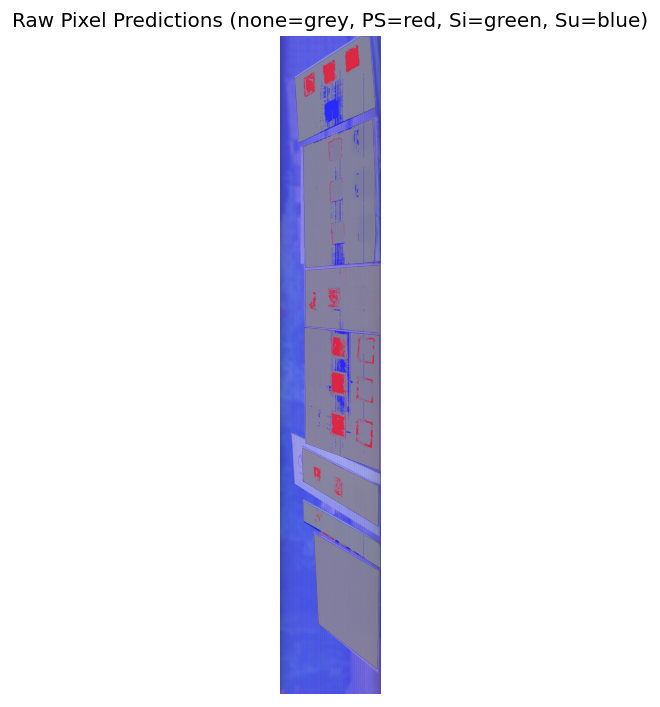

Saved raw pixel prediction map: /content/drive/MyDrive/HSI/data/08-35-10/Standart_2017-10-16_08-35-10_XCOR_raw_pixel_predictions.png
Saving RAW pixel correctness map...


In [113]:
RUN_CORR_ONCE = 1
if RUN_CORR_ONCE:
  print("Running cross correlation baseline...")
  # cc_data = prepare_infrence_data(rd = False)
  cc_res = evaluate_reference_baseline(cc_data, diff_thresh=0.4, sigma_smooth=2.0, LBR=300)

  rgb = cc_data["cube"][:, :, [120, 42, 0]].astype(float)
  for i in range(3):
      m = rgb[:, :, i].max()
      if m > 0:
          rgb[:, :, i] /= m

  print("Saving RAW pixel prediction color map..")
  save_raw_prediction_color_map(cc_data["label_map"], cc_data["coords_eval"], cc_res["preds"], rgb, OUT_PREFIX.replace(MODEL_NAME, "XCOR"),)

  print("Saving RAW pixel correctness map...")
  save_pixel_class_map(cc_data["label_map"], cc_data["coords_eval"], cc_data["test_meta"], cc_res["preds"], rgb, OUT_PREFIX.replace(MODEL_NAME, "XCOR"))